#Coastal hyperparameter tuning

##Libraries

Cargar paquetes

In [1]:
import pickle
import joblib
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import pandas as pd
import seaborn as sns
import geopandas as gpd
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, matthews_corrcoef, roc_auc_score, jaccard_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##Database download

###Load dataset 2022

In [2]:
# Definir la URL para cargar el archivo Excel que contiene datos sobre contaminantes de aguas costeras

#costero_completo = pd.read_excel('/content/coastal_contaminants_2012-2022.xlsx')
url_costero_completo = "https://raw.githubusercontent.com/Ricardo8932/Paper/main/Database/Coastal/coastal_contaminants_2012-2022_p.xlsx"
url_costero_sites = "https://raw.githubusercontent.com/Ricardo8932/Paper/main/Database/Coastal/coastal_sites.xlsx"

In [3]:
# Cargar el DataFrame 'costero' desde un archivo Excel en la URL especificada

costero_completo = pd.read_excel(url_costero_completo)
costero_sites = pd.read_excel(url_costero_sites)

###Load dataset 2023

In [4]:
# Definir la URL para cargar el archivo Excel que contiene datos sobre contaminantes de aguas costeras

#url_costero=("https://raw.githubusercontent.com/Ricardo8932/Proyecto_Conagua_Final_Tesis/main/Costero/al_2023/costero_contaminantes.xlsx")

In [5]:
# Cargar el DataFrame 'costero' desde un archivo Excel en la URL especificada

#costero = pd.read_excel(url_costero)

##Preprocessing

In [6]:
costero = costero_completo.copy()

In [7]:
# Obtener los índices (números de fila) del DataFrame 'costero' y almacenarlos en la variable 'costero_row_idx'
costero_row_idx = costero.index
costero_row_idx

RangeIndex(start=0, stop=23456, step=1)

In [8]:
# Obtener los nombres de las columnas del DataFrame 'costero' y almacenarlos en la variable 'costero_col_idx'
costero_col_idx = costero.columns

# Mostrar los nombres de las columnas del DataFrame 'costero'
costero_col_idx


Index(['CLAVE SITIO', 'CLAVE MONITOREO', 'NOMBRE DEL SITIO',
       'TIPO CUERPO DE AGUA', 'FECHA REALIZACIÓN', 'AÑO', 'SST', 'CF', 'ODs%',
       'ODm%', 'ODf%', 'EF', 'TOX_F15s', 'TOX_F15f'],
      dtype='object')

In [9]:
# Mostrar los tipos de datos de cada columna en el DataFrame 'costero'
costero.dtypes


,0
CLAVE SITIO,object
CLAVE MONITOREO,object
NOMBRE DEL SITIO,object
TIPO CUERPO DE AGUA,object
FECHA REALIZACIÓN,datetime64[ns]
AÑO,int64
SST,object
CF,object
ODs%,object
ODm%,object


In [10]:
# Mostrar las primeras 5 filas del DataFrame 'costero'
costero.head()

,CLAVE SITIO,CLAVE MONITOREO,NOMBRE DEL SITIO,TIPO CUERPO DE AGUA,FECHA REALIZACIÓN,AÑO,SST,CF,ODs%,ODm%,ODf%,EF,TOX_F15s,TOX_F15f
0,DLBAJ100,DLBAJ100-281012,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2012-11-12,2012,<10,<3,90.1,89.5,95.1,10,<1,<1
1,DLBAJ100,DLBAJ100-231212,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-01-07,2013,24,41,82.1,NaN,85.5,<3,<1,<1
2,DLBAJ100,DLBAJ100-070413,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-04-01,2013,34.3333,<1,110.17,NaN,NaN,<1,<1,<1
3,DLBAJ100,DLBAJ100-090613,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-06-03,2013,10.25,75,103.7,100.2,100.2,<1,<1,<1
4,DLBAJ100,DLBAJ100-110813,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-08-09,2013,<10,<1,89.5,92.01,93,<1,<1,<1


In [11]:
# Contar el número de valores nulos en cada columna del DataFrame 'costero'
costero.isnull().sum()

,0
CLAVE SITIO,0
CLAVE MONITOREO,0
NOMBRE DEL SITIO,0
TIPO CUERPO DE AGUA,0
FECHA REALIZACIÓN,0
AÑO,0
SST,166
CF,1026
ODs%,1099
ODm%,14416


In [12]:
# Mostrar un resumen conciso del DataFrame 'costero'
costero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23456 entries, 0 to 23455
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          23456 non-null  object        
 1   CLAVE MONITOREO      23456 non-null  object        
 2   NOMBRE DEL SITIO     23456 non-null  object        
 3   TIPO CUERPO DE AGUA  23456 non-null  object        
 4   FECHA REALIZACIÓN    23456 non-null  datetime64[ns]
 5   AÑO                  23456 non-null  int64         
 6   SST                  23290 non-null  object        
 7   CF                   22430 non-null  object        
 8   ODs%                 22357 non-null  object        
 9   ODm%                 9040 non-null   object        
 10  ODf%                 7440 non-null   object        
 11  EF                   23137 non-null  object        
 12  TOX_F15s             23181 non-null  object        
 13  TOX_F15f             14857 non-

In [13]:
# Obtener los nombres de las columnas del DataFrame 'costero'
columns = costero.columns.values

# Reemplazar caracteres específicos en todas las columnas del DataFrame
costero[columns] = costero[columns].replace({'<':''}, regex=True)  # Eliminar el símbolo '<'
costero[columns] = costero[columns].replace({'>':''}, regex=True)  # Eliminar el símbolo '>'
costero[columns] = costero[columns].replace({'≤':''}, regex=True)  # Eliminar el símbolo '≤'
costero[columns] = costero[columns].replace({'≥':''}, regex=True)  # Eliminar el símbolo '≥'

In [14]:
# Mostrar las primeras 5 filas del DataFrame 'costero' para verificar si se han eliminado los signos '<, ≤' y '>, ≥'
costero.head()

,CLAVE SITIO,CLAVE MONITOREO,NOMBRE DEL SITIO,TIPO CUERPO DE AGUA,FECHA REALIZACIÓN,AÑO,SST,CF,ODs%,ODm%,ODf%,EF,TOX_F15s,TOX_F15f
0,DLBAJ100,DLBAJ100-281012,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2012-11-12,2012,10,3,90.1,89.5,95.1,10,1,1
1,DLBAJ100,DLBAJ100-231212,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-01-07,2013,24,41,82.1,NaN,85.5,3,1,1
2,DLBAJ100,DLBAJ100-070413,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-04-01,2013,34.3333,1,110.17,NaN,NaN,1,1,1
3,DLBAJ100,DLBAJ100-090613,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-06-03,2013,10.25,75,103.7,100.2,100.2,1,1,1
4,DLBAJ100,DLBAJ100-110813,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-08-09,2013,10,1,89.5,92.01,93,1,1,1


In [15]:
# Seleccionar las columnas del DataFrame 'costero' que se desean convertir a tipo numérico (índices del 6 al 13)
columns_to_convert = costero.columns[6:14]

# Convertir las columnas seleccionadas a tipo numérico; cualquier valor que no pueda ser convertido se convertirá en NaN
costero[columns_to_convert] = costero[columns_to_convert].apply(pd.to_numeric, errors='coerce')


In [16]:
# Seleccionar las columnas del DataFrame 'costero' desde la columna 13 hasta la 20 (excluyendo la 21) usando iloc
selected_columns = costero.iloc[:, 6:14]

# Mostrar las primeras 10 filas del DataFrame 'selected_columns'
selected_columns.head(10)


,SST,CF,ODs%,ODm%,ODf%,EF,TOX_F15s,TOX_F15f
0,10.0000,3.0,90.10,89.50,95.1,10.0,1.0,1.0
1,24.0000,41.0,82.10,NaN,85.5,3.0,1.0,1.0
2,34.3333,1.0,110.17,NaN,NaN,1.0,1.0,1.0
3,10.2500,75.0,103.70,100.20,100.2,1.0,1.0,1.0
4,10.0000,1.0,89.50,92.01,93.0,1.0,1.0,1.0
5,21.2500,265.0,105.80,105.90,105.8,10.0,1.0,1.0
6,13.0000,41.0,109.30,107.20,105.1,1.0,1.0,1.0
7,10.0000,2613.0,92.80,92.70,90.7,1.0,1.0,1.0
8,10.0000,218.0,97.00,99.30,105.3,1.0,1.0,1.0
9,10.0000,1.0,106.00,100.60,102.1,1.0,1.0,1.0


In [17]:
# Mostrar información general sobre el DataFrame 'costero'
costero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23456 entries, 0 to 23455
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          23456 non-null  object        
 1   CLAVE MONITOREO      23456 non-null  object        
 2   NOMBRE DEL SITIO     23456 non-null  object        
 3   TIPO CUERPO DE AGUA  23456 non-null  object        
 4   FECHA REALIZACIÓN    23456 non-null  datetime64[ns]
 5   AÑO                  23456 non-null  int64         
 6   SST                  23290 non-null  float64       
 7   CF                   22430 non-null  float64       
 8   ODs%                 22357 non-null  float64       
 9   ODm%                 9040 non-null   float64       
 10  ODf%                 7440 non-null   float64       
 11  EF                   23137 non-null  float64       
 12  TOX_F15s             23181 non-null  float64       
 13  TOX_F15f             14857 non-

In [18]:
# Cambiar el tipo de datos de las columnas 'AÑO', 'LATITUD' y 'LONGITUD' a 'object' en el DataFrame 'costero'
costero = costero.astype({'AÑO':'object','FECHA REALIZACIÓN':'object'})

In [19]:
# Obtener estadísticas descriptivas de las columnas numéricas del DataFrame 'costero'
costero.describe()

,SST,CF,ODs%,ODm%,ODf%,EF,TOX_F15s,TOX_F15f
count,23290.000000,22430.000000,22357.000000,9040.000000,7440.00000,23137.000000,23181.000000,14857.000000
mean,56.702114,1510.340660,84.959395,83.150245,80.51307,417.827765,1.035384,1.034754
std,167.116255,5356.001794,25.306520,23.384332,24.90048,2575.548958,1.000825,0.954894
min,10.000000,1.000000,10.000000,10.000000,2.50000,1.000000,1.000000,1.000000
25%,12.000000,4.000000,67.900000,68.000000,64.63750,3.000000,1.000000,1.000000
50%,24.000000,30.000000,88.000000,86.900000,85.00000,10.000000,1.000000,1.000000
75%,52.000000,282.000000,101.100000,99.500000,98.80000,20.000000,1.000000,1.000000
max,15003.500000,241960.000000,187.000000,150.000000,150.00000,34480.000000,74.630000,48.076900


In [20]:
# Selecciona las columnas 6 a 13
columnas_especificas = costero.iloc[:, 6:14]

# Aplica dropna() solo a esas columnas
costero_preprocesado = costero.dropna(subset=columnas_especificas.columns)

In [21]:
# Mostrar información resumida sobre el DataFrame 'costero'
costero_preprocesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5340 entries, 0 to 23397
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5340 non-null   object 
 1   CLAVE MONITOREO      5340 non-null   object 
 2   NOMBRE DEL SITIO     5340 non-null   object 
 3   TIPO CUERPO DE AGUA  5340 non-null   object 
 4   FECHA REALIZACIÓN    5340 non-null   object 
 5   AÑO                  5340 non-null   object 
 6   SST                  5340 non-null   float64
 7   CF                   5340 non-null   float64
 8   ODs%                 5340 non-null   float64
 9   ODm%                 5340 non-null   float64
 10  ODf%                 5340 non-null   float64
 11  EF                   5340 non-null   float64
 12  TOX_F15s             5340 non-null   float64
 13  TOX_F15f             5340 non-null   float64
dtypes: float64(8), object(6)
memory usage: 625.8+ KB


In [22]:
# Guardar el DataFrame 'costero' en un archivo Excel llamado 'costero_preprocesado.xlsx'
costero_preprocesado.to_excel("costero_preprocesado.xlsx")

##Water quality

###Funciones para las columnas 'calidad_' y 'cumple_'


In [23]:
# Crea un nuevo DataFrame 'data_costero' asignando valores NaN a las columnas para la calidad del agua y el cumplimiento de cada contaminante
data_costero = costero_preprocesado.assign(calidad_SST=np.nan,calidad_CF=np.nan,calidad_ODs=np.nan,calidad_ODm=np.nan,calidad_ODf=np.nan,calidad_EF=np.nan,calidad_TOX_F15s=np.nan,calidad_TOX_F15f=np.nan,
                              cumple_SST=np.nan,cumple_CF=np.nan,cumple_ODs=np.nan,cumple_ODm=np.nan,cumple_ODf=np.nan,cumple_EF=np.nan,cumple_TOX_F15s=np.nan,cumple_TOX_F15f=np.nan)

In [24]:
data_costero.columns

Index(['CLAVE SITIO', 'CLAVE MONITOREO', 'NOMBRE DEL SITIO',
       'TIPO CUERPO DE AGUA', 'FECHA REALIZACIÓN', 'AÑO', 'SST', 'CF', 'ODs%',
       'ODm%', 'ODf%', 'EF', 'TOX_F15s', 'TOX_F15f', 'calidad_SST',
       'calidad_CF', 'calidad_ODs', 'calidad_ODm', 'calidad_ODf', 'calidad_EF',
       'calidad_TOX_F15s', 'calidad_TOX_F15f', 'cumple_SST', 'cumple_CF',
       'cumple_ODs', 'cumple_ODm', 'cumple_ODf', 'cumple_EF',
       'cumple_TOX_F15s', 'cumple_TOX_F15f'],
      dtype='object')

In [25]:
# Mostrar información general sobre las nuevas columnas agregadas al DataFrame data_costero
data_costero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5340 entries, 0 to 23397
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5340 non-null   object 
 1   CLAVE MONITOREO      5340 non-null   object 
 2   NOMBRE DEL SITIO     5340 non-null   object 
 3   TIPO CUERPO DE AGUA  5340 non-null   object 
 4   FECHA REALIZACIÓN    5340 non-null   object 
 5   AÑO                  5340 non-null   object 
 6   SST                  5340 non-null   float64
 7   CF                   5340 non-null   float64
 8   ODs%                 5340 non-null   float64
 9   ODm%                 5340 non-null   float64
 10  ODf%                 5340 non-null   float64
 11  EF                   5340 non-null   float64
 12  TOX_F15s             5340 non-null   float64
 13  TOX_F15f             5340 non-null   float64
 14  calidad_SST          0 non-null      float64
 15  calidad_CF           0 non-null      float

Función para la columna calidad_

In [26]:
#---------------------------calidad_SST---------------------------------------------------------------------------------
col = 'SST'
conditions  = [ data_costero[col] <= 25, (data_costero[col] > 25) & (data_costero[col] <= 75), (data_costero[col] > 75) & (data_costero[col] <= 150),
               (data_costero[col] > 150) & (data_costero[col] <= 400), data_costero[col] > 400 ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_costero['calidad_SST'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_CF-------------------------------------------------------------------
col = 'CF'
conditions  = [ data_costero[col] <= 100, (data_costero[col] > 100) & (data_costero[col] <= 200), (data_costero[col] > 200) & (data_costero[col] <= 1000),
               (data_costero[col] > 1000) & (data_costero[col] <= 10000), data_costero[col] > 10000 ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_costero['calidad_CF'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_ODs-------------------------------------------------------------------------
col = 'ODs%'
conditions  = [ (data_costero[col] > 70) & (data_costero[col] <= 110),
                (((data_costero[col] > 50) & (data_costero[col] <= 70))|((data_costero[col] > 110)&(data_costero[col] <= 120))),
                (((data_costero[col] > 30) & (data_costero[col] <= 50))|((data_costero[col] > 120)&(data_costero[col] <= 130))),
                (((data_costero[col] > 10) & (data_costero[col] <= 30))|((data_costero[col] > 130)&(data_costero[col] <= 150))),
                ((data_costero[col] <= 10)|(data_costero[col] > 150)) ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_costero['calidad_ODs'] = np.select(conditions, choices, default=np.nan)


#---------------------------calidad_ODm-------------------------------------------------------------------------
col = 'ODm%'
conditions  = [ (data_costero[col] > 70) & (data_costero[col] <= 110),
                (((data_costero[col] > 50) & (data_costero[col] <= 70))|((data_costero[col] > 110)&(data_costero[col] <= 120))),
                (((data_costero[col] > 30) & (data_costero[col] <= 50))|((data_costero[col] > 120)&(data_costero[col] <= 130))),
                (((data_costero[col] > 10) & (data_costero[col] <= 30))|((data_costero[col] > 130)&(data_costero[col] <= 150))),
                ((data_costero[col] <= 10)|(data_costero[col] > 150)) ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_costero['calidad_ODm'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_ODf-------------------------------------------------------------------------
col = 'ODf%'
conditions  = [ (data_costero[col] > 70) & (data_costero[col] <= 110),
                (((data_costero[col] > 50) & (data_costero[col] <= 70))|((data_costero[col] > 110)&(data_costero[col] <= 120))),
                (((data_costero[col] > 30) & (data_costero[col] <= 50))|((data_costero[col] > 120)&(data_costero[col] <= 130))),
                (((data_costero[col] > 10) & (data_costero[col] <= 30))|((data_costero[col] > 130)&(data_costero[col] <= 150))),
                ((data_costero[col] <= 10)|(data_costero[col] > 150)) ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_costero['calidad_ODf'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_EF--------------------------------------------------------------------------------
col = 'EF'
conditions  = [ data_costero[col] <= 100, (data_costero[col] > 100) & (data_costero[col] <= 200), (data_costero[col] > 200) & (data_costero[col] <= 500), data_costero[col] > 500 ]
choices     = [ 'Excelente', 'Buena calidad', 'Contaminada', 'Fuertemente contaminada']
data_costero['calidad_EF'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_TOX_F15s---------------------------------------------------------------------
col = 'TOX_F15s'
conditions  = [(data_costero[col] < 1), (data_costero[col] >= 1) & (data_costero[col] <= 1.33), (data_costero[col] > 1.33) & (data_costero[col] < 5), data_costero[col] >= 5 ]
choices     = [ 'No tóxico', 'Toxicidad baja', 'Toxicidad moderada', 'Toxicidad alta' ]
data_costero['calidad_TOX_F15s'] = np.select(conditions, choices, default=np.nan)


#---------------------------calidad_TOX_F15f---------------------------------------------------------------------
col = 'TOX_F15f'
conditions  = [(data_costero[col] < 1), (data_costero[col] >= 1) & (data_costero[col] <= 1.33), (data_costero[col] > 1.33) & (data_costero[col] < 5), data_costero[col] >= 5 ]
choices     = [ 'No tóxico', 'Toxicidad baja', 'Toxicidad moderada', 'Toxicidad alta' ]
data_costero['calidad_TOX_F15f'] = np.select(conditions, choices, default=np.nan)

In [27]:
data_costero.iloc[:5, 14:21] #Columnas tipo de calidad_

,calidad_SST,calidad_CF,calidad_ODs,calidad_ODm,calidad_ODf,calidad_EF,calidad_TOX_F15s
0,Excelente,Excelente,Excelente,Excelente,Excelente,Excelente,Toxicidad baja
3,Excelente,Excelente,Excelente,Excelente,Excelente,Excelente,Toxicidad baja
4,Excelente,Excelente,Excelente,Excelente,Excelente,Excelente,Toxicidad baja
5,Excelente,Aceptable,Excelente,Excelente,Excelente,Excelente,Toxicidad baja
6,Excelente,Excelente,Excelente,Excelente,Excelente,Excelente,Toxicidad baja


In [28]:
data_costero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5340 entries, 0 to 23397
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5340 non-null   object 
 1   CLAVE MONITOREO      5340 non-null   object 
 2   NOMBRE DEL SITIO     5340 non-null   object 
 3   TIPO CUERPO DE AGUA  5340 non-null   object 
 4   FECHA REALIZACIÓN    5340 non-null   object 
 5   AÑO                  5340 non-null   object 
 6   SST                  5340 non-null   float64
 7   CF                   5340 non-null   float64
 8   ODs%                 5340 non-null   float64
 9   ODm%                 5340 non-null   float64
 10  ODf%                 5340 non-null   float64
 11  EF                   5340 non-null   float64
 12  TOX_F15s             5340 non-null   float64
 13  TOX_F15f             5340 non-null   float64
 14  calidad_SST          5340 non-null   object 
 15  calidad_CF           5340 non-null   objec

Function for the 'cumple_' column

In [29]:
#---------------------------cumple_SST-----------------------------------------------------
col = 'calidad_SST'
conditions  = [ data_costero[col] == 'Excelente', data_costero[col] == 'Buena calidad', data_costero[col] == 'Aceptable', data_costero[col] == 'Contaminada', data_costero[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_costero['cumple_SST'] = np.select(conditions, choices, default=np.nan)
data_costero['cumple_SST'] = data_costero['cumple_SST'].astype('int32')

#---------------------------cumple_CF-----------------------------------------------------
col = 'calidad_CF'
conditions  = [ data_costero[col] == 'Excelente', data_costero[col] == 'Buena calidad', data_costero[col] == 'Aceptable', data_costero[col] == 'Contaminada', data_costero[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_costero['cumple_CF'] = np.select(conditions, choices, default=np.nan)
data_costero['cumple_CF'] = data_costero['cumple_CF'].astype('int32')

#---------------------------cumple_ODs-----------------------------------------------------
col = 'calidad_ODs'
conditions  = [ data_costero[col] == 'Excelente', data_costero[col] == 'Buena calidad', data_costero[col] == 'Aceptable', data_costero[col] == 'Contaminada', data_costero[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_costero['cumple_ODs'] = np.select(conditions, choices, default=np.nan)
data_costero['cumple_ODs'] = data_costero['cumple_ODs'].astype('int32')

#---------------------------cumple_ODm-----------------------------------------------------
col = 'calidad_ODm'
conditions  = [ data_costero[col] == 'Excelente', data_costero[col] == 'Buena calidad', data_costero[col] == 'Aceptable', data_costero[col] == 'Contaminada', data_costero[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_costero['cumple_ODm'] = np.select(conditions, choices, default=np.nan)
data_costero['cumple_ODm'] = data_costero['cumple_ODm'].astype('int32')

#---------------------------cumple_ODf-----------------------------------------------------
col = 'calidad_ODf'
conditions  = [ data_costero[col] == 'Excelente', data_costero[col] == 'Buena calidad', data_costero[col] == 'Aceptable', data_costero[col] == 'Contaminada', data_costero[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_costero['cumple_ODf'] = np.select(conditions, choices, default=np.nan)
data_costero['cumple_ODf'] = data_costero['cumple_ODf'].astype('int32')

#---------------------------cumple_EF-----------------------------------------------------
col = 'calidad_EF'
conditions  = [ data_costero[col] == 'Excelente', data_costero[col] == 'Buena calidad', data_costero[col] == 'Contaminada', data_costero[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 0, 0 ]
data_costero['cumple_EF'] = np.select(conditions, choices, default=np.nan)
data_costero['cumple_EF'] = data_costero['cumple_EF'].astype('int32')

#---------------------------cumple_TOX_F15s-----------------------------------------------------
col = 'calidad_TOX_F15s'
conditions  = [ data_costero[col] == 'No tóxico', data_costero[col] == 'Toxicidad baja', data_costero[col] == 'Toxicidad moderada', data_costero[col] == 'Toxicidad alta']
choices     = [ 1, 1, 1, 0 ]
data_costero['cumple_TOX_F15s'] = np.select(conditions, choices, default=np.nan)
data_costero['cumple_TOX_F15s'] = data_costero['cumple_TOX_F15s'].astype('int32')

#---------------------------cumple_TOX_F15f-----------------------------------------------------
col = 'calidad_TOX_F15f'
conditions  = [ data_costero[col] == 'No tóxico', data_costero[col] == 'Toxicidad baja', data_costero[col] == 'Toxicidad moderada', data_costero[col] == 'Toxicidad alta']
choices     = [ 1, 1, 1, 0 ]
data_costero['cumple_TOX_F15f'] = np.select(conditions, choices, default=np.nan)
data_costero['cumple_TOX_F15f'] = data_costero['cumple_TOX_F15f'].astype('int32')

In [30]:
data_costero.iloc[:5, 22:] #cumple_ columns

,cumple_SST,cumple_CF,cumple_ODs,cumple_ODm,cumple_ODf,cumple_EF,cumple_TOX_F15s,cumple_TOX_F15f
0,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1


In [31]:
data_costero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5340 entries, 0 to 23397
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5340 non-null   object 
 1   CLAVE MONITOREO      5340 non-null   object 
 2   NOMBRE DEL SITIO     5340 non-null   object 
 3   TIPO CUERPO DE AGUA  5340 non-null   object 
 4   FECHA REALIZACIÓN    5340 non-null   object 
 5   AÑO                  5340 non-null   object 
 6   SST                  5340 non-null   float64
 7   CF                   5340 non-null   float64
 8   ODs%                 5340 non-null   float64
 9   ODm%                 5340 non-null   float64
 10  ODf%                 5340 non-null   float64
 11  EF                   5340 non-null   float64
 12  TOX_F15s             5340 non-null   float64
 13  TOX_F15f             5340 non-null   float64
 14  calidad_SST          5340 non-null   object 
 15  calidad_CF           5340 non-null   objec

Asignación de la calidad del agua

In [32]:
conditions  = [(data_costero['cumple_TOX_F15s'] == 0) | (data_costero['cumple_TOX_F15f'] == 0) | (data_costero['cumple_EF'] == 0),
               (data_costero['cumple_CF'] == 0) | (data_costero['cumple_SST'] == 0) | (data_costero['cumple_ODs'] == 0) | (data_costero['cumple_ODm'] == 0) | (data_costero['cumple_ODf'] == 0),
               (data_costero['cumple_CF'] == 1) & (data_costero['cumple_TOX_F15s'] == 1) & (data_costero['cumple_TOX_F15f'] == 1) & (data_costero['cumple_ODs'] == 1) & (data_costero['cumple_ODm'] == 1) & (data_costero['cumple_ODf'] == 1) & (data_costero['cumple_EF'] == 1) & (data_costero['cumple_SST'] == 1)]
choices     = [2, 1, 0]
data_costero['Calidad del agua'] = np.select(conditions, choices, default=np.nan)
data_costero['Calidad del agua'] = data_costero['Calidad del agua'].astype('int32')

In [33]:
data_costero.iloc[:5, 22:]

,cumple_SST,cumple_CF,cumple_ODs,cumple_ODm,cumple_ODf,cumple_EF,cumple_TOX_F15s,cumple_TOX_F15f,Calidad del agua
0,1,1,1,1,1,1,1,1,0
3,1,1,1,1,1,1,1,1,0
4,1,1,1,1,1,1,1,1,0
5,1,1,1,1,1,1,1,1,0
6,1,1,1,1,1,1,1,1,0


In [34]:
data_costero.to_excel("costero_contaminantes_calidad_cumple_calidad_del_agua.xlsx")

In [35]:
df_costero_calidad_del_agua = data_costero.iloc[:, list(range(0, 14)) + [30]]
df_costero_calidad_del_agua.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5340 entries, 0 to 23397
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5340 non-null   object 
 1   CLAVE MONITOREO      5340 non-null   object 
 2   NOMBRE DEL SITIO     5340 non-null   object 
 3   TIPO CUERPO DE AGUA  5340 non-null   object 
 4   FECHA REALIZACIÓN    5340 non-null   object 
 5   AÑO                  5340 non-null   object 
 6   SST                  5340 non-null   float64
 7   CF                   5340 non-null   float64
 8   ODs%                 5340 non-null   float64
 9   ODm%                 5340 non-null   float64
 10  ODf%                 5340 non-null   float64
 11  EF                   5340 non-null   float64
 12  TOX_F15s             5340 non-null   float64
 13  TOX_F15f             5340 non-null   float64
 14  Calidad del agua     5340 non-null   int32  
dtypes: float64(8), int32(1), object(6)
memory 

In [36]:
df_costero_calidad_del_agua.to_excel("costero_contaminantes_calidad_del_agua.xlsx")

##Separation by years

In [37]:
costero_sp = costero_completo.copy()

In [38]:
costero_p = costero_preprocesado.copy()

Sin procesar

In [39]:
df_total_sp = pd.DataFrame(costero_sp)

# Contar datos por año
conteo_por_año = df_total_sp['AÑO'].value_counts()

print(conteo_por_año)

AÑO
2013    3788
2014    3477
2015    3455
2018    3442
2016    3404
2017    3397
2012     993
2020     830
2019     289
2022     222
2021     159
Name: count, dtype: int64


In [40]:
# Obtener el número de registros
numero_de_registros_sp = df_total_sp.shape[0]

print(f"El número total de registros del dataframe es: {numero_de_registros_sp}")

El número total de registros del dataframe es: 23456


Procesado

In [41]:
df_total_p = pd.DataFrame(costero_p)

# Contar datos por año
conteo_por_año = df_total_p['AÑO'].value_counts()

print(conteo_por_año)

AÑO
2013    1311
2014    1134
2015     827
2016     758
2017     560
2018     428
2012     252
2019      49
2022      21
Name: count, dtype: int64


In [42]:
# Obtener el número de registros
numero_de_registros_p = df_total_p.shape[0]

print(f"El número total de registros del dataframe es: {numero_de_registros_p}")

El número total de registros del dataframe es: 5340


Calidad del agua

In [43]:
df_costero_calidad_del_agua.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5340 entries, 0 to 23397
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5340 non-null   object 
 1   CLAVE MONITOREO      5340 non-null   object 
 2   NOMBRE DEL SITIO     5340 non-null   object 
 3   TIPO CUERPO DE AGUA  5340 non-null   object 
 4   FECHA REALIZACIÓN    5340 non-null   object 
 5   AÑO                  5340 non-null   object 
 6   SST                  5340 non-null   float64
 7   CF                   5340 non-null   float64
 8   ODs%                 5340 non-null   float64
 9   ODm%                 5340 non-null   float64
 10  ODf%                 5340 non-null   float64
 11  EF                   5340 non-null   float64
 12  TOX_F15s             5340 non-null   float64
 13  TOX_F15f             5340 non-null   float64
 14  Calidad del agua     5340 non-null   int32  
dtypes: float64(8), int32(1), object(6)
memory 

In [44]:
df_total_calidad = pd.DataFrame(df_costero_calidad_del_agua)

# Contar datos por año
conteo_por_año = df_total_calidad['AÑO'].value_counts()

print(conteo_por_año)

AÑO
2013    1311
2014    1134
2015     827
2016     758
2017     560
2018     428
2012     252
2019      49
2022      21
Name: count, dtype: int64


###al año 2021

####Calidad del agua

In [45]:
# Filtrar valores entre 2012 y 2021 (inclusive)
df_costero_calidad_del_agua_2021 = df_costero_calidad_del_agua[(df_costero_calidad_del_agua['AÑO'] >= 2012) & (df_costero_calidad_del_agua['AÑO'] <= 2021)]

In [46]:
df_costero_calidad_del_agua_2021 = df_costero_calidad_del_agua_2021.iloc[:, 6:21]

####Sin procesar

In [47]:
# Filtrar valores entre 2012 y 2021 (inclusive)
df_2012_al_2021_sp = df_total_sp[(df_total_sp['AÑO'] >= 2012) & (df_total_sp['AÑO'] <= 2021)]

# Obtener el número de registros
numero_de_registros_sp = df_2012_al_2021_sp.shape[0]

print(f"El número total de registros del periodo 2012 - 2021 es: {numero_de_registros_sp}")

El número total de registros del periodo 2012 - 2021 es: 23234


####Procesado

In [48]:
# Filtrar valores entre 2012 y 2021 (inclusive)
df_2012_al_2021_p = df_total_p[(df_total_p['AÑO'] >= 2012) & (df_total_p['AÑO'] <= 2021)]

# Obtener el número de registros
numero_de_registros_p = df_2012_al_2021_p.shape[0]

print(f"El número total de registros del periodo 2012 - 2021 es: {numero_de_registros_p}")

El número total de registros del periodo 2012 - 2021 es: 5319


###al año 2022

####Sin procesar

In [49]:
# Filtrar valores entre 2012 y 2022 (inclusive)
df_2012_al_2022_sp = df_total_sp[(df_total_sp['AÑO'] >= 2012) & (df_total_sp['AÑO'] <= 2022)]

# Obtener el número de registros
numero_de_registros_sp = df_2012_al_2022_sp.shape[0]

print(f"El número total de registros del periodo 2012 - 2022 es: {numero_de_registros_sp}")

El número total de registros del periodo 2012 - 2022 es: 23456


Total de registros limpios del periodo 2012-2022

####Procesado

In [50]:
# Filtrar valores entre 2012 y 2022 (inclusive)
df_2012_al_2022_p = df_total_p[(df_total_p['AÑO'] >= 2012) & (df_total_p['AÑO'] <= 2022)]

# Obtener el número de registros
numero_de_registros_p = df_2012_al_2022_p.shape[0]

print(f"El número total de registros del periodo 2012 - 2022 es: {numero_de_registros_p}")

El número total de registros del periodo 2012 - 2022 es: 5340


###al año 2023

####Sin procesar

In [51]:
# Filtrar valores entre 2012 y 2023 (inclusive)
df_2012_al_2023_sp = df_total_sp[(df_total_sp['AÑO'] >= 2012) & (df_total_sp['AÑO'] <= 2023)]

# Obtener el número de registros
numero_de_registros_sp = df_2012_al_2023_sp.shape[0]

print(f"El número total de registros del periodo 2012 - 2023 es: {numero_de_registros_sp}")

El número total de registros del periodo 2012 - 2023 es: 23456


####Procesado

In [52]:
# Filtrar valores entre 2012 y 2023 (inclusive)
df_2012_al_2023_p = df_total_p[(df_total_p['AÑO'] >= 2012) & (df_total_p['AÑO'] <= 2023)]

# Obtener el número de registros
numero_de_registros_p = df_2012_al_2023_p.shape[0]

print(f"El número total de registros del periodo 2012 - 2023 es: {numero_de_registros_p}")

El número total de registros del periodo 2012 - 2023 es: 5340


##Exploratory Data Analysis (EDA)

In [53]:
# Imprimir un mensaje que indica que se mostrará el total de datos del periodo 2012-2023
print("Total de datos del periodo 2012 - 2023: ")

# Mostrar las dimensiones del DataFrame 'costero' (filas y columnas) como una forma de entender el tamaño del conjunto de datos
costero.shape


Total de datos del periodo 2012 - 2023: 


(23456, 14)

In [54]:
# Suponiendo que tu DataFrame se llama df
conteo_2023 = costero[costero['AÑO'] == 2023].shape[0]
print(f"El número de registros con AÑO 2023 es: {conteo_2023}")

El número de registros con AÑO 2023 es: 0


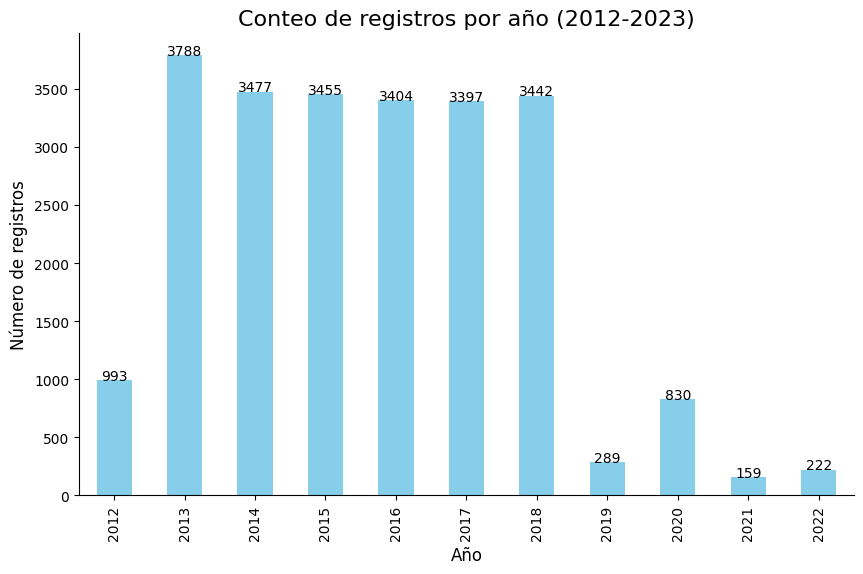

In [55]:
# Agrupar los datos por 'AÑO' y contar cuántos registros hay por cada año
conteo_por_año = costero['AÑO'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_por_año.plot(kind='bar', color='skyblue')

# Configurar el título y las etiquetas de los ejes
plt.title('Conteo de registros por año (2012-2023)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de registros', fontsize=12)

# Mostrar los valores de las barras encima de cada barra
for index, value in enumerate(conteo_por_año):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=10)

# Ocultar los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Mostrar el gráfico
plt.show()


In [56]:
#Codigo para sacar el total de muestras descargadas
#solo del 2012 al 2021, el conjunto de datos es del 2012 al 2023
#por lo tanto se tiene que excluir el año 2022 y el 2023 y crear
#un nuevo dataframe que se llame costero_2012_2021 y obtendremos
#el total de muestras de ese periodo

In [57]:
#Despues de ese conjunto de datos se crea un dataframe que llamaremos
#costero_2012_2021 y a ese dataframe hay que aplicarle el
#dropna para que nos de el resultado de total de muestras limpias

####Otras estadisticas

In [58]:
# Agrupar por año y contar los valores de la columna "Water quality" para cada grupo
conteo_por_año = df_costero_calidad_del_agua.groupby('AÑO')['Calidad del agua'].value_counts().unstack(fill_value=0)

# Definir los nombres de las columnas
nombres_columnas = ['Good', 'Regular', 'Poor']

# Asignar los nombres a las columnas del dataframe
conteo_por_año.columns = nombres_columnas

# Mostrar el resultado
conteo_por_año

,Good,Regular,Poor
AÑO,,,
2012,195,41,16
2013,829,371,111
2014,809,226,99
2015,643,127,57
2016,586,133,39
2017,430,68,62
2018,349,33,46
2019,41,4,4
2022,16,5,0


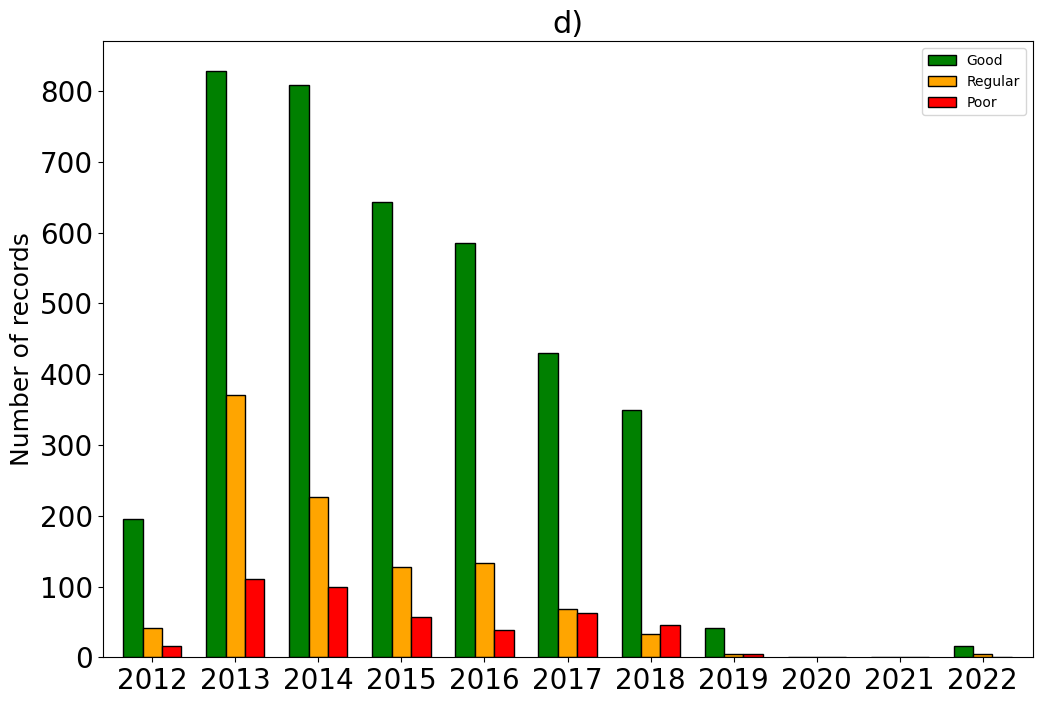

In [59]:
# Crear el DataFrame con tus datos
data = conteo_por_año  # Esto asume que ya tienes los datos de conteo_por_año
index = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]  # Los años disponibles
df = pd.DataFrame(data, index=index)

# Definir una lista de colores para cada categoría
colores = {
    'Good': 'green',
    'Regular': 'orange',
    'Poor': 'red'
}

# Graficar
df.plot(kind='bar', figsize=(12, 8), color=[colores[categoria] for categoria in df.columns], edgecolor='black', width=0.7)

# Configuración de etiquetas y título
plt.title('d)', fontsize=22)  # Título
plt.xlabel('', fontsize=20)  # Etiqueta del eje X
plt.ylabel('Number of records', fontsize=18)  # Etiqueta del eje Y

# Ajustar el tamaño de las etiquetas del eje X e Y
plt.xticks(rotation=0, fontsize=20)  # Etiquetas del eje X
plt.yticks(fontsize=20)  # Etiquetas del eje Y

# Mostrar el gráfico
plt.show()


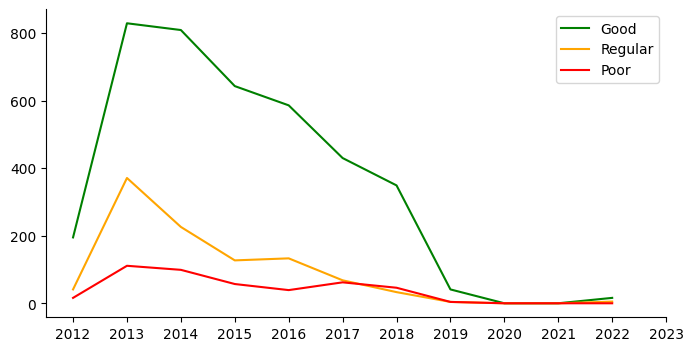

In [60]:
# Crear un rango de años de 2012 a 2023
rango_anos = pd.Index(range(2012, 2023))

# Asegurarse de que todos los años estén presentes, incluso si faltan datos
conteo_por_año = conteo_por_año.reindex(rango_anos, fill_value=0)

# Trazar las tres líneas en la misma figura
plt.figure(figsize=(8, 4))

# Colores: Verde para 'Buena', Naranja para 'Regular', Rojo para 'Mala'
conteo_por_año['Good'].plot(kind='line', color='green', label='Good')
conteo_por_año['Regular'].plot(kind='line', color='orange', label='Regular')
conteo_por_año['Poor'].plot(kind='line', color='red', label='Poor')

# Configurar el título y etiquetas de los ejes
plt.title('')
plt.xlabel('')
plt.ylabel('')

# Asegurarse de que los años del 2012 al 2023 aparezcan en el eje x
plt.xticks(rotation=0, fontsize=10, ticks=range(2012, 2024), labels=range(2012, 2024))

# Ocultar los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [61]:
conteo_por_año = conteo_por_año.T

In [62]:
# Obtener el número de valores de la clase Good para el año seleccionado
año = 2015
registros_good = conteo_por_año.loc['Good', año]
print(f"Número de valores de la clase Buena en el año {año}:", registros_good)

Número de valores de la clase Buena en el año 2015: 643


In [63]:
# Obtener el número de valores de la clase Regular para el año seleccionado
año = 2015
registros_regular = conteo_por_año.loc['Regular', año]
print(f"Número de valores de la clase Regular en el año {año}:", registros_regular)

Número de valores de la clase Regular en el año 2015: 127


In [64]:
# Obtener el número de valores de la clase Good para el año seleccionado
año = 2015
registros_poor = conteo_por_año.loc['Poor', año]
print(f"Número de valores de la clase Mala en el año {año}:", registros_poor)

Número de valores de la clase Mala en el año 2015: 57


##Statistical Analysis of Coastal Body

###Union de dataframes

In [65]:
# Unir los DataFrames a través de la columna "CLAVE SITIO"
costero_contaminants_combined = pd.merge(
    costero_preprocesado,  # DataFrame principal
    costero_sites[['CLAVE SITIO', 'ORGANISMO CUENCA']],  # Seleccionar solo las columnas necesarias del otro DataFrame
    on='CLAVE SITIO',  # Columna común para realizar la unión
    how='left'  # Tipo de unión: 'left' conserva todos los registros del DataFrame principal
)

# Mostrar el DataFrame resultante
#print(costero_contaminants_combined)


In [66]:
costero_contaminants_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5340 entries, 0 to 5339
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5340 non-null   object 
 1   CLAVE MONITOREO      5340 non-null   object 
 2   NOMBRE DEL SITIO     5340 non-null   object 
 3   TIPO CUERPO DE AGUA  5340 non-null   object 
 4   FECHA REALIZACIÓN    5340 non-null   object 
 5   AÑO                  5340 non-null   object 
 6   SST                  5340 non-null   float64
 7   CF                   5340 non-null   float64
 8   ODs%                 5340 non-null   float64
 9   ODm%                 5340 non-null   float64
 10  ODf%                 5340 non-null   float64
 11  EF                   5340 non-null   float64
 12  TOX_F15s             5340 non-null   float64
 13  TOX_F15f             5340 non-null   float64
 14  ORGANISMO CUENCA     5340 non-null   object 
dtypes: float64(8), object(7)
memory usage:

In [67]:
# Filtrar valores entre 2012 y 2022 (inclusive)
costero_contaminants_combined_2022 = costero_contaminants_combined[(costero_contaminants_combined['AÑO'] >= 2012) & (costero_contaminants_combined['AÑO'] <= 2022)]

In [68]:
costero_contaminants_combined_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5340 entries, 0 to 5339
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5340 non-null   object 
 1   CLAVE MONITOREO      5340 non-null   object 
 2   NOMBRE DEL SITIO     5340 non-null   object 
 3   TIPO CUERPO DE AGUA  5340 non-null   object 
 4   FECHA REALIZACIÓN    5340 non-null   object 
 5   AÑO                  5340 non-null   object 
 6   SST                  5340 non-null   float64
 7   CF                   5340 non-null   float64
 8   ODs%                 5340 non-null   float64
 9   ODm%                 5340 non-null   float64
 10  ODf%                 5340 non-null   float64
 11  EF                   5340 non-null   float64
 12  TOX_F15s             5340 non-null   float64
 13  TOX_F15f             5340 non-null   float64
 14  ORGANISMO CUENCA     5340 non-null   object 
dtypes: float64(8), object(7)
memory usage:

###No cumplimiento

####Porcentaje de no cumplimiento por contaminante y cuenca

In [69]:
df2 = costero_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits2 = {
    'SST': lambda x: x > 150,
    'CF': lambda x: x > 1000,
    'ODs%': lambda x: x <= 30 or x > 130,
    'ODm%': lambda x: x <= 30 or x > 130,
    'ODf%': lambda x: x <= 30 or x > 130,
    'EF': lambda x: x > 200,
    'TOX_F15s': lambda x: x >= 5,
    'TOX_F15f': lambda x: x >= 5
}

# Crear una columna de no cumplimiento para cada parámetro
for col, condition in limits2.items():
    df2[f'{col}_no_cumple'] = df2[col].apply(condition)

# Calcular el porcentaje de no cumplimiento por parámetro para cada cuenca
non_compliance_summary = pd.DataFrame()
for col in limits2.keys():
    non_compliance_summary[col] = df2.groupby('ORGANISMO CUENCA')[f'{col}_no_cumple'].mean() * 100

# Mostrar el DataFrame con los resultados de no cumplimiento
non_compliance_summary.to_excel('porcentaje_costero_no_cumplimiento_limites.xlsx')

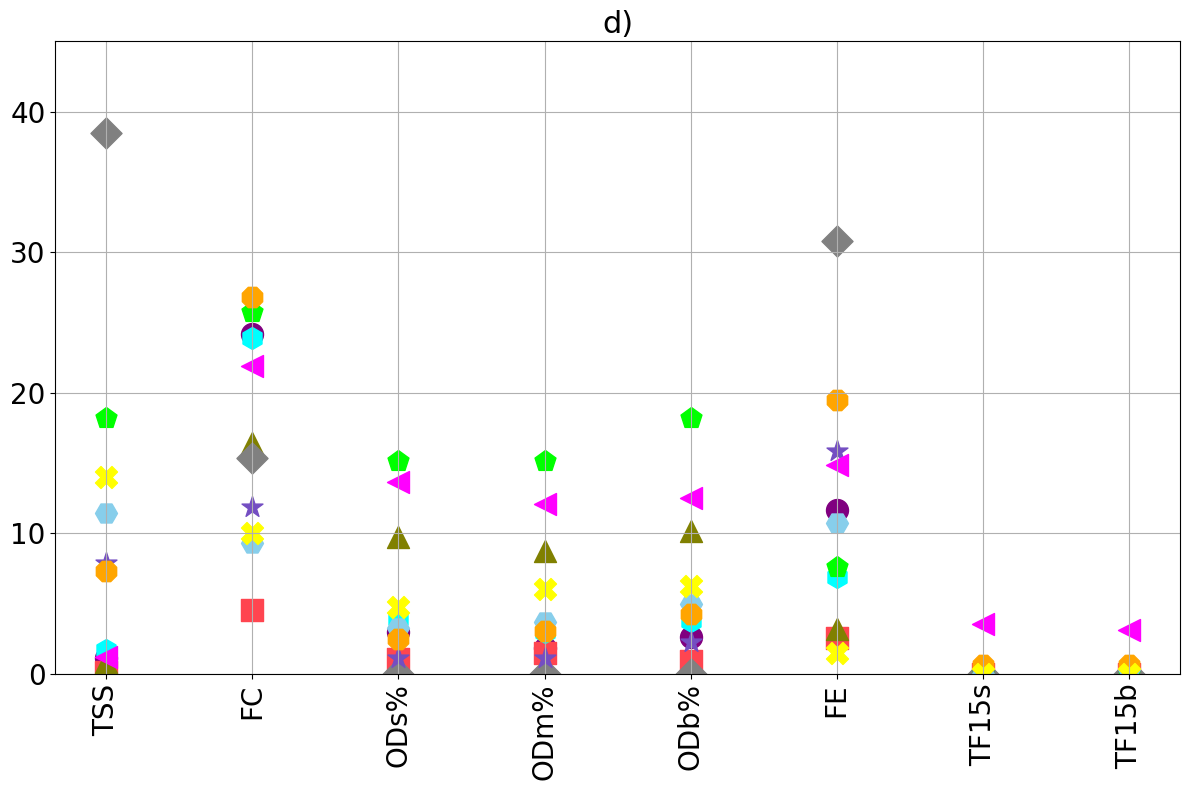

In [70]:
df2 = costero_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits2 = {
    'SST': lambda x: x <= 150,
    'CF': lambda x: x <= 1000,
    'ODs%': lambda x: 30 < x <= 130,
    'ODm%': lambda x: 30 < x <= 130,
    'ODf%': lambda x: 30 < x <= 130,
    'EF': lambda x: x <= 200,
    'TOX_F15s': lambda x: x < 5,
    'TOX_F15f': lambda x: x < 5
}

# Crear una columna de cumplimiento para cada parámetro
for col, condition in limits2.items():
    df2[f'{col}_compliance'] = df2[col].apply(condition)

# Calcular el porcentaje de no cumplimiento por parámetro para cada cuenca
compliance_summary2 = pd.DataFrame()
for col in limits2.keys():
    compliance_summary2[col] = df2.groupby('ORGANISMO CUENCA')[f'{col}_compliance'].mean() * 100

# Diccionario para renombrar las columnas en el gráfico
column_names_mapping = {
    'SST': 'TSS',
    'CF': 'FC',
    'ODs%': 'ODs%',
    'ODm%': 'ODm%',
    'ODf%': 'ODb%',
    'EF': 'FE',
    'TOX_F15s': 'TF15s',
    'TOX_F15f': 'TF15b'
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Colores y marcadores para cada cuenca
cuencas2 = {
    'LERMA SANTIAGO PACÍFICO': ('#800080', 'o'),
    'PENÍNSULA DE BAJA CALIFORNIA': ('#FF4550', 's'),
    'PENÍNSULA DE YUCATÁN': ('#808000', '^'),
    'RÍO BRAVO': ('#808080', 'D'),
    'PACÍFICO NORTE': ('#00FFFF', 'h'),
    'BALSAS': ('#00FF00', 'p'),
    'GOLFO NORTE': ('#744EC2', '*'),
    'PACÍFICO SUR': ('#87CEEB', 'H'),
    'GOLFO CENTRO': ('#FFA500', '8'),
    'FRONTERA SUR': ('#FFFF00', 'X'),
    'NOROESTE': ('#FF00FF', '<'),
}

# Graficar puntos para cada cuenca y parámetro
for cuenca in cuencas2:
    for j, col in enumerate(limits2.keys()):
        color, marker = cuencas2.get(cuenca, ('gray', 'o'))
        ax.scatter(
            [column_names_mapping[col]],  # Usar los nombres mapeados
            [100 - compliance_summary2.loc[cuenca, col]],  # % de no cumplimiento
            marker=marker,
            color=color,
            label=f'{cuenca}' if j == 0 else "",
            s=250
        )

# Configuración del eje Y
ax.set_ylim(0, 45)
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_ylabel('', fontsize=20)
ax.tick_params(axis='y', labelsize=20)

# Configuración del eje X
ax.set_xlabel('', fontsize=14, fontweight='bold')
ax.set_xticks(list(column_names_mapping.values()))  # Mostrar los nombres mapeados
ax.set_xticklabels(list(column_names_mapping.values()), fontsize=20, rotation=90)
ax.tick_params(axis='x', labelsize=20)  # Tamaño de fuente del eje X

# Título del gráfico
ax.set_title('d)', fontsize=22)

# Ajustar la leyenda para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# (Descomentar si deseas incluir una leyenda)
# ax.legend(
#     by_label.values(),
#     by_label.keys(),
#     title='Cuencas',
#     title_fontsize=14,
#     fontsize=12,
#     loc='upper center',
#     bbox_to_anchor=(0.5, -0.1),
#     ncol=5
# )

# Agregar cuadrícula y mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


####Número total de registros de no cumplimiento por contaminante y cuenca

In [71]:
df1 = costero_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda para identificar los valores que no cumplen
limits1 = {
    'SST': lambda x: x > 150,
    'CF': lambda x: x > 1000,
    'ODs%': lambda x: x <= 30 or x > 130,
    'ODm%': lambda x: x <= 30 or x > 130,
    'ODf%': lambda x: x <= 30 or x > 130,
    'EF': lambda x: x > 200,
    'TOX_F15s': lambda x: x >= 5,
    'TOX_F15f': lambda x: x >= 5
}

# Crear una columna de no cumplimiento para cada parámetro
for col, condition in limits1.items():
    df1[f'{col}_no_cumple'] = df1[col].apply(condition)

# Calcular el número total de no cumplimiento por parámetro para cada cuenca
non_compliance_summary1 = pd.DataFrame()
for col in limits1.keys():
    non_compliance_summary1[col] = df1.groupby('ORGANISMO CUENCA')[f'{col}_no_cumple'].sum()

# Mostrar el DataFrame con los resultados de no cumplimiento
#print(non_compliance_summary1)
non_compliance_summary1.to_excel('total_costero_no_cumplimiento_limites.xlsx')

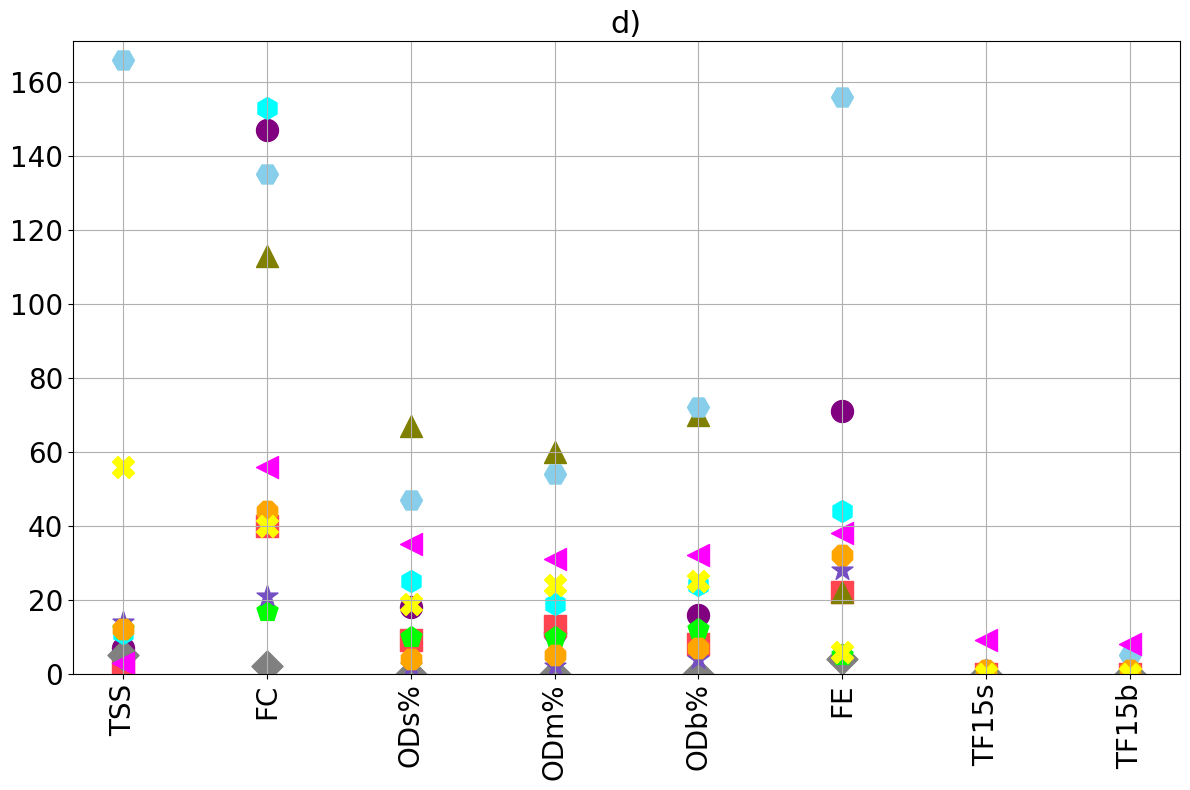

In [72]:
df1 = costero_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits1 = {
    'SST': lambda x: x <= 150,
    'CF': lambda x: x <= 1000,
    'ODs%': lambda x: 30 < x <= 130,
    'ODm%': lambda x: 30 < x <= 130,
    'ODf%': lambda x: 30 < x <= 130,
    'EF': lambda x: x <= 200,
    'TOX_F15s': lambda x: x < 5,
    'TOX_F15f': lambda x: x < 5
}

# Crear una columna de cumplimiento para cada parámetro
for col, condition in limits1.items():
    df1[f'{col}_compliance'] = df1[col].apply(condition)

# Calcular el número total de no cumplimiento por parámetro para cada cuenca
non_compliance_summary1 = pd.DataFrame()
for col in limits1.keys():
    non_compliance_summary1[col] = df1.groupby('ORGANISMO CUENCA')[f'{col}_compliance'].apply(lambda x: x.size - x.sum())

# Diccionario para renombrar las columnas en el gráfico
column_names_mapping = {
    'SST': 'TSS',
    'CF': 'FC',
    'ODs%': 'ODs%',
    'ODm%': 'ODm%',
    'ODf%': 'ODb%',
    'EF': 'FE',
    'TOX_F15s': 'TF15s',
    'TOX_F15f': 'TF15b'
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Colores y marcadores para cada cuenca
cuencas1 = {
    'LERMA SANTIAGO PACÍFICO': ('#800080', 'o'),
    'PENÍNSULA DE BAJA CALIFORNIA': ('#FF4550', 's'),
    'PENÍNSULA DE YUCATÁN': ('#808000', '^'),
    'RÍO BRAVO': ('#808080', 'D'),
    'PACÍFICO NORTE': ('#00FFFF', 'h'),
    'BALSAS': ('#00FF00', 'p'),
    'GOLFO NORTE': ('#744EC2', '*'),
    'PACÍFICO SUR': ('#87CEEB', 'H'),
    'GOLFO CENTRO': ('#FFA500', '8'),
    'FRONTERA SUR': ('#FFFF00', 'X'),
    'NOROESTE': ('#FF00FF', '<'),
}

# Graficar puntos para cada cuenca y parámetro
for cuenca in cuencas1:
    for j, col in enumerate(limits1.keys()):
        color, marker = cuencas1.get(cuenca, ('gray', 'o'))
        ax.scatter(
            [column_names_mapping[col]],  # Usar nombres mapeados
            [non_compliance_summary1.loc[cuenca, col]],
            marker=marker,
            color=color,
            label=f'{cuenca}' if j == 0 else "",
            s=250
        )

# Configuración del eje Y
ax.set_ylim(0, non_compliance_summary1.max().max() + 5)
ax.set_ylabel('', fontsize=20)
ax.tick_params(axis='y', labelsize=20)

# Configuración del eje X
ax.set_xlabel('', fontsize=14, fontweight='bold')
ax.set_xticks(list(column_names_mapping.values()))
ax.set_xticklabels(list(column_names_mapping.values()), fontsize=20, rotation=90)
ax.tick_params(axis='x', labelsize=20)  # Tamaño de fuente del eje X

# Título del gráfico
ax.set_title('d)', fontsize=22)

# Ajustar la leyenda para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# (Descomentar si deseas incluir una leyenda)
# ax.legend(
#     by_label.values(),
#     by_label.keys(),
#     title='Cuencas',
#     title_fontsize=14,
#     fontsize=12,
#     loc='upper center',
#     bbox_to_anchor=(0.5, -0.1),
#     ncol=5
# )

# Agregar cuadrícula y mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


##Data visualization

In [73]:
df_2012_al_2021_sp = df_2012_al_2021_sp.iloc[:, 6:20]
df_2012_al_2022_sp = df_2012_al_2022_sp.iloc[:, 6:20]
df_2012_al_2023_sp = df_2012_al_2023_sp.iloc[:, 6:20]

In [74]:
df_2012_al_2021_p = df_2012_al_2021_p.iloc[:, 6:20]
df_2012_al_2022_p = df_2012_al_2022_p.iloc[:, 6:20]
df_2012_al_2023_p = df_2012_al_2023_p.iloc[:, 6:20]

In [75]:
# Diccionario para renombrar las columnas
nombres_columnas = {
    'SST': 'TSS',
    'CF': 'FC',
    'ODs%': 'ODs%',
    'ODm%': 'ODm%',
    'ODf%': 'ODb%',
    'EF': 'FE',
    'TOX_F15s': 'TD48s',
    'TOX_F15f': 'TF15b'
}

# Renombrar las columnas
df_2012_al_2021_sp = df_2012_al_2021_sp.rename(columns=nombres_columnas)

# Renombrar las columnas
df_2012_al_2021_p = df_2012_al_2021_p.rename(columns=nombres_columnas)

###Mapa de calor de simbolos > y <

####al 2021

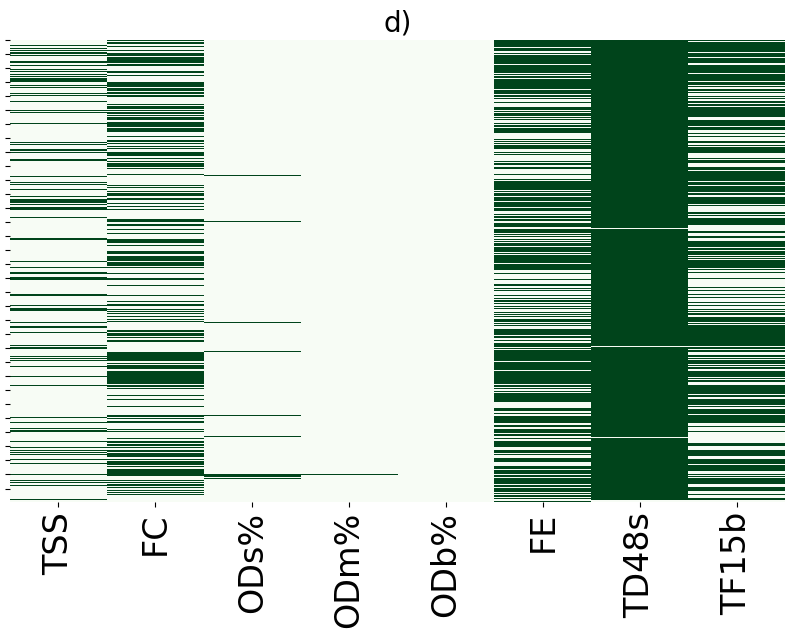

In [76]:
# Crear una matriz booleana donde True indica presencia de < o >
bool_matrix = df_2012_al_2021_sp.applymap(lambda x: '<' in str(x) or '>' in str(x))

# Crear un heatmap de la matriz booleana para todas las columnas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Generar el heatmap basado en la matriz booleana
heatmap = sns.heatmap(bool_matrix, cbar=False, cmap='Greens')  # Usar 'Greens'

# Rotar las etiquetas del eje X 90 grados y aumentar el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establecer las etiquetas del eje Y a una lista vacía para eliminarlas
heatmap.set_yticklabels([])

# Configurar el título y la etiqueta del eje X
plt.title('d)', loc='center', fontsize=20)
plt.xlabel('', loc='center', fontsize=20)

# Mostrar el heatmap
plt.show()


####al 2022

####al 2023

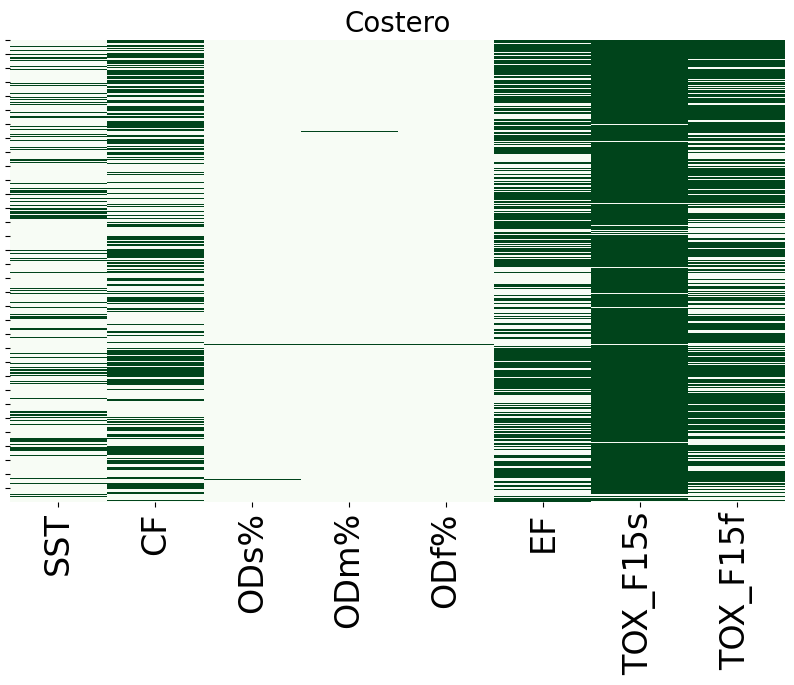

In [77]:
# Crear una matriz booleana donde True indica presencia de < o >
bool_matrix = df_2012_al_2023_sp.applymap(lambda x: '<' in str(x) or '>' in str(x))

# Crear un heatmap de la matriz booleana para todas las columnas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Generar el heatmap basado en la matriz booleana
heatmap = sns.heatmap(bool_matrix, cbar=False, cmap='Greens')  # Usar 'Greens'

# Rotar las etiquetas del eje X 90 grados y aumentar el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establecer las etiquetas del eje Y a una lista vacía para eliminarlas
heatmap.set_yticklabels([])

# Configurar el título y la etiqueta del eje X
plt.title('Costero', loc='center', fontsize=20)
plt.xlabel('', loc='center', fontsize=20)

# Mostrar el heatmap
plt.show()


###Mapa de calor de valores nulos

####al 2021

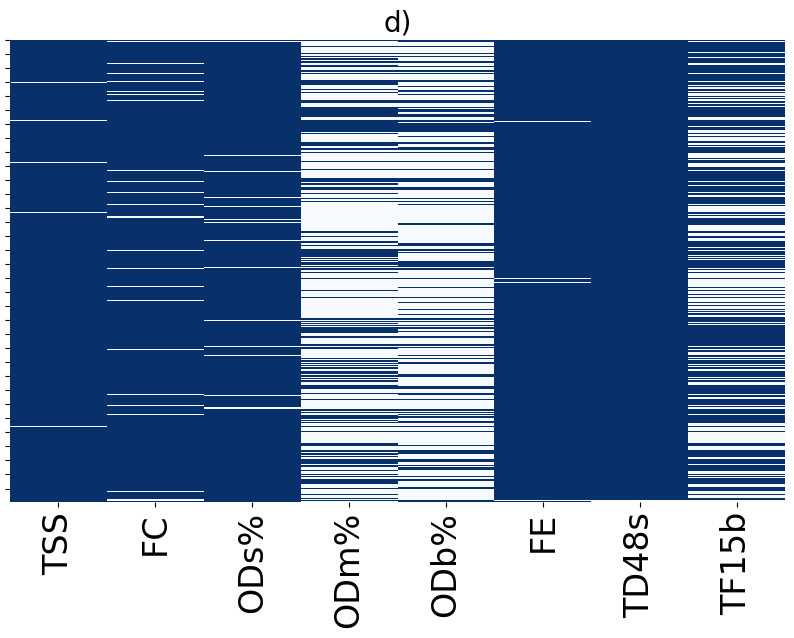

In [78]:
# Seleccionar las columnas que deseas incluir en el mapa de calor
columnas_seleccionadas_costero = df_2012_al_2021_sp.columns  # Reemplaza con el rango de nombres de columnas que deseas

# Crear un mapa de calor de valores faltantes para todas las columnas del DataFrame
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Generar un mapa de calor mostrando la presencia de valores faltantes
heatmap = sns.heatmap(df_2012_al_2021_sp.isnull(), cbar=False, cmap='Blues_r')

# Rotar las etiquetas del eje x 90 grados para que sean verticales y aumentar el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establecer las etiquetas del eje y como una lista vacía para eliminarlas
heatmap.set_yticklabels([])

plt.title('d)', loc='center', fontsize=20)  # Título del gráfico
plt.xlabel('', loc='center', fontsize=20)  # Etiqueta del eje x
plt.show()  # Muestra el gráfico

####al 2022

####al_2023

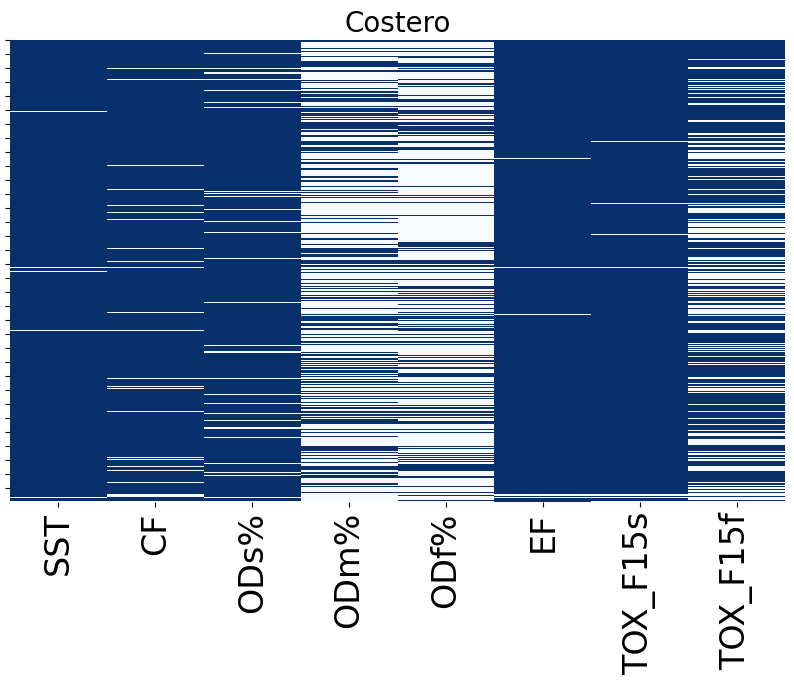

In [79]:
# Seleccionar las columnas que deseas incluir en el mapa de calor
columnas_seleccionadas_costero = df_2012_al_2023_sp.columns  # Reemplaza con el rango de nombres de columnas que deseas

# Crear un mapa de calor de valores faltantes solo para las columnas seleccionadas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Genera un mapa de calor que muestra la presencia de valores faltantes en las columnas seleccionadas
heatmap = sns.heatmap(df_2012_al_2023_sp[columnas_seleccionadas_costero].isnull(), cbar=False, cmap='Blues_r')

# Rotea las etiquetas del eje x 90 grados para que sean verticales y aumenta el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establece las etiquetas del eje y como una lista vacía para eliminarlas
heatmap.set_yticklabels([])

plt.title('Costero', loc='center', fontsize=20)  # Título del gráfico
plt.xlabel('', loc='center', fontsize=20)  # Etiqueta del eje x
plt.show()  # Muestra el gráfico


###Mapa de calor de correlación de valores nulos entre contaminantes

####al 2021

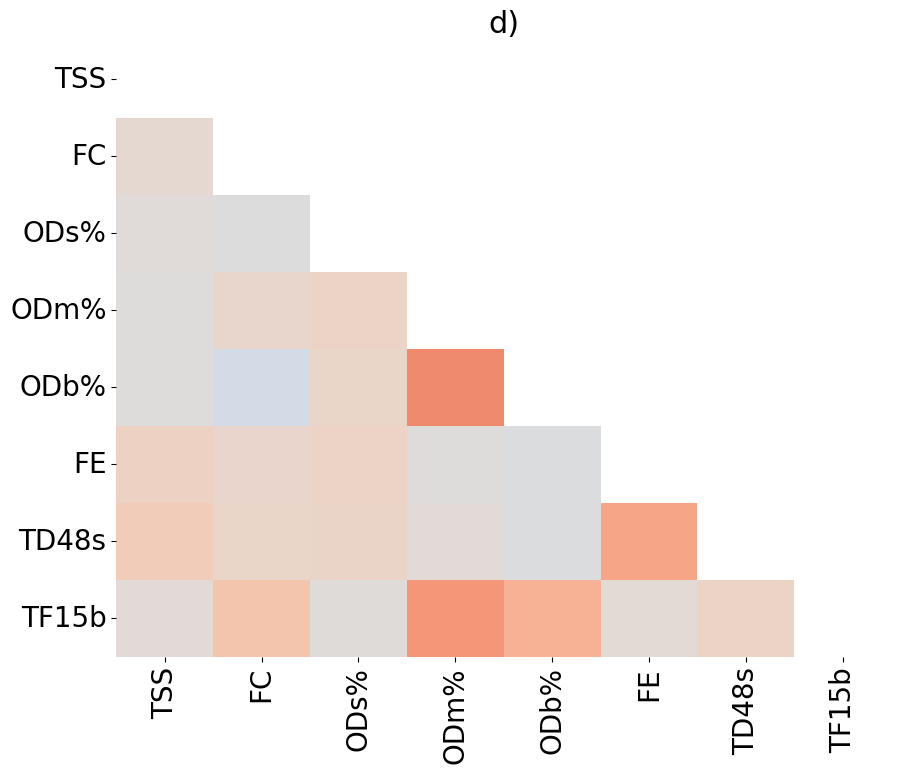

In [80]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2021_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('d)', fontsize=22)
plt.show()


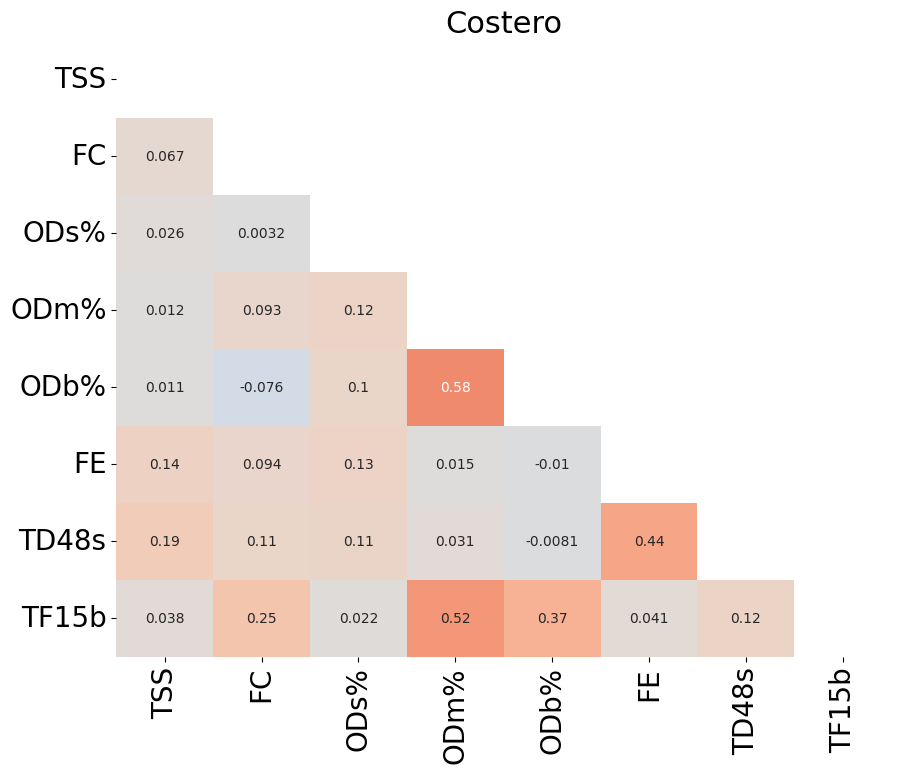

In [81]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2021_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero', fontsize=22)
plt.show()

####al 2022

####al 2023

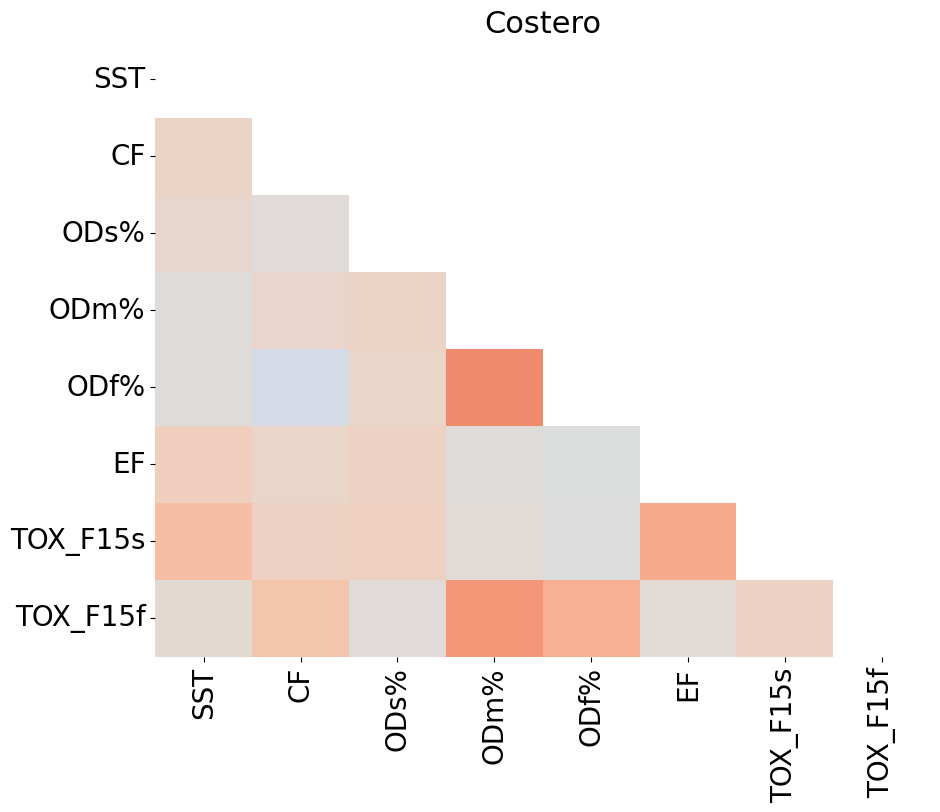

In [82]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2023_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero', fontsize=22)
plt.show()


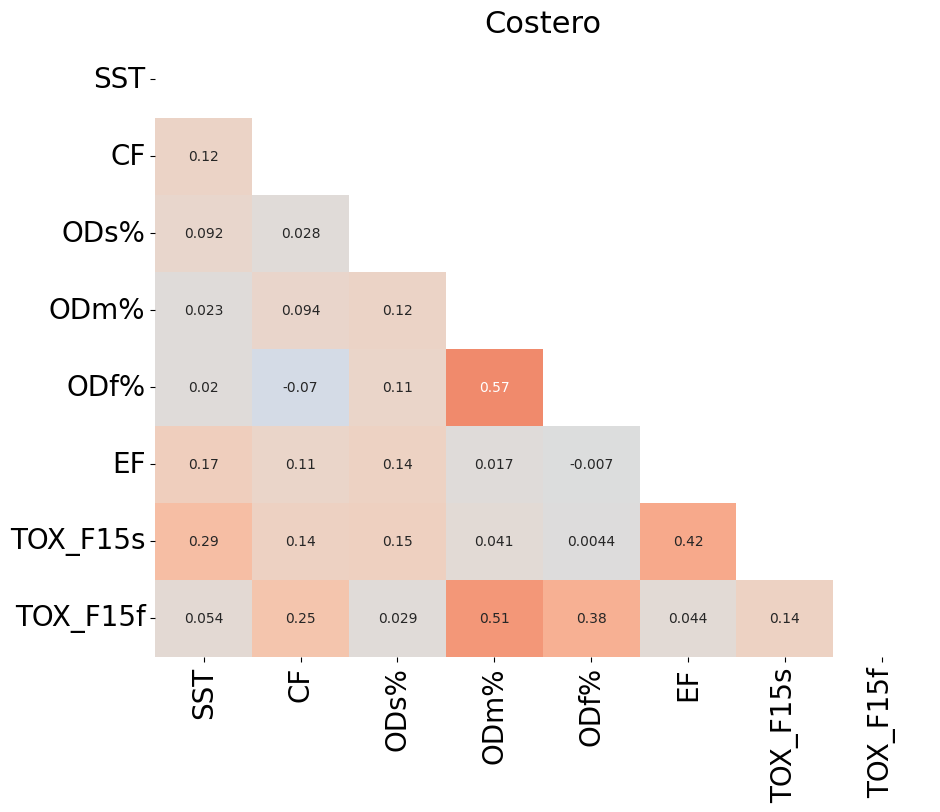

In [83]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2023_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero', fontsize=22)
plt.show()

###Mapa de calor de correlación lineal

####al 2021

#####Coeficiente de correlación de Pearson

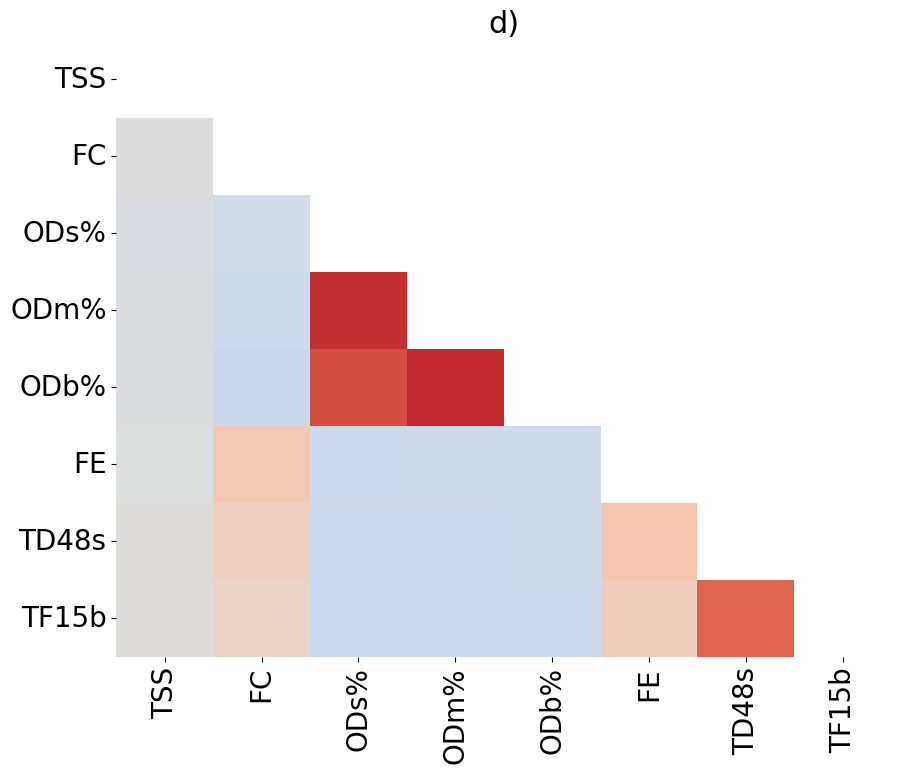

In [84]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('d)', fontsize=22)

# Mostrar el gráfico
plt.show()

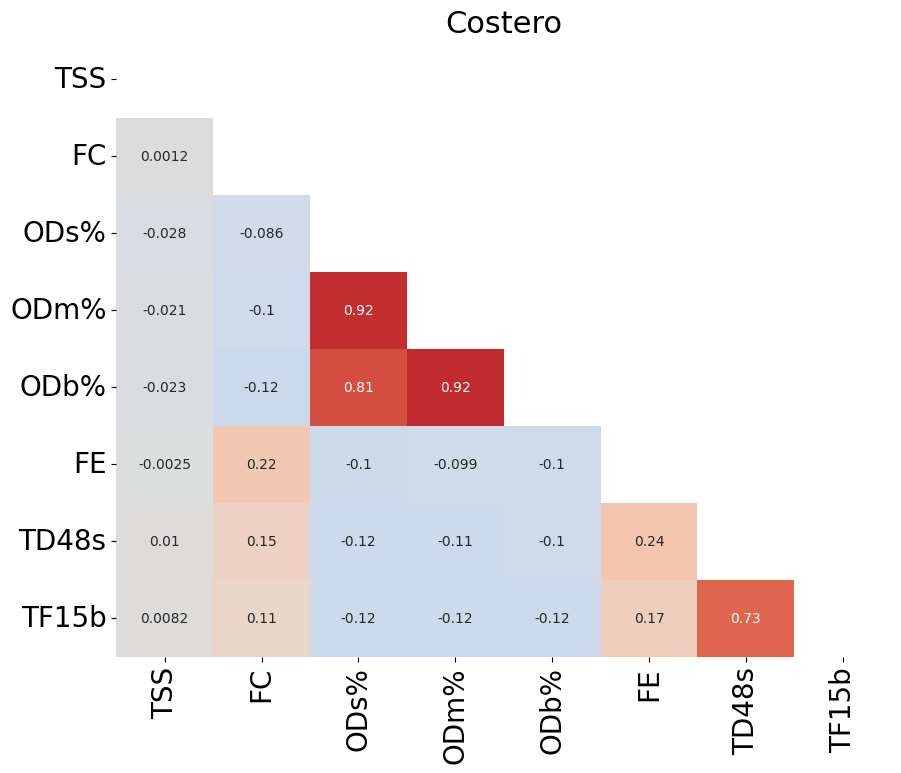

In [85]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero', fontsize=22)

# Mostrar el gráfico
plt.show()

#####Coeficiente de correlación de Spearman

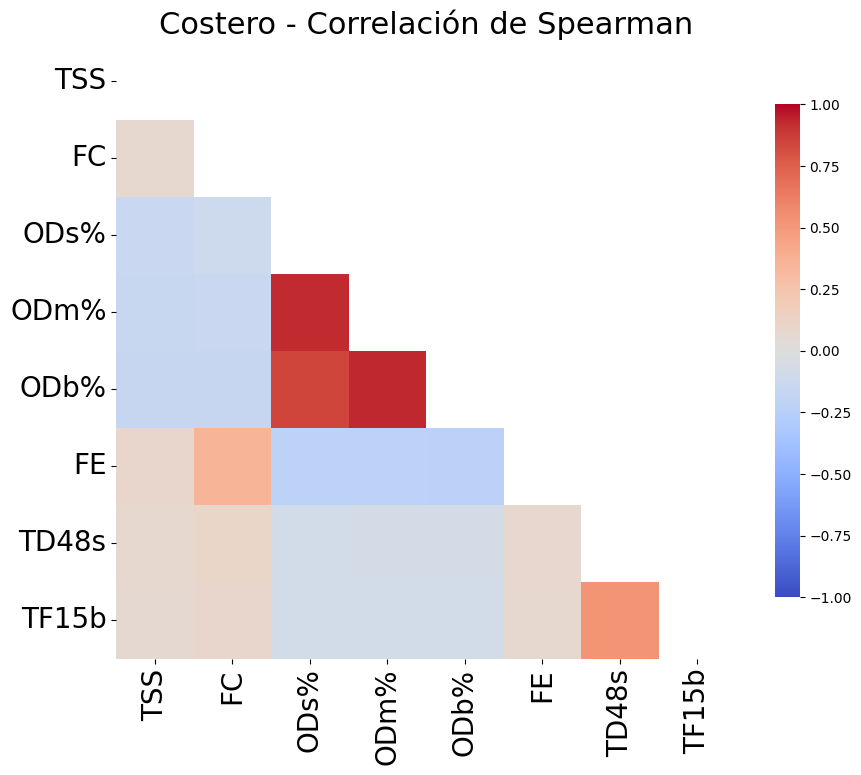

In [86]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


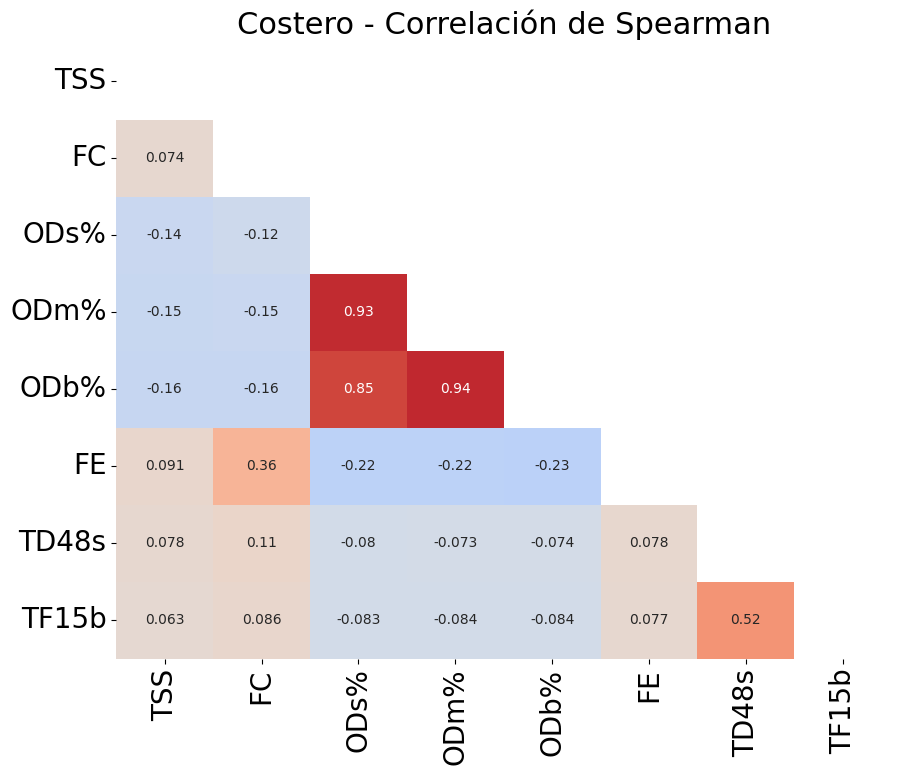

In [87]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


####al 2022

####al 2023

#####Coeficiente de correlación de Pearson

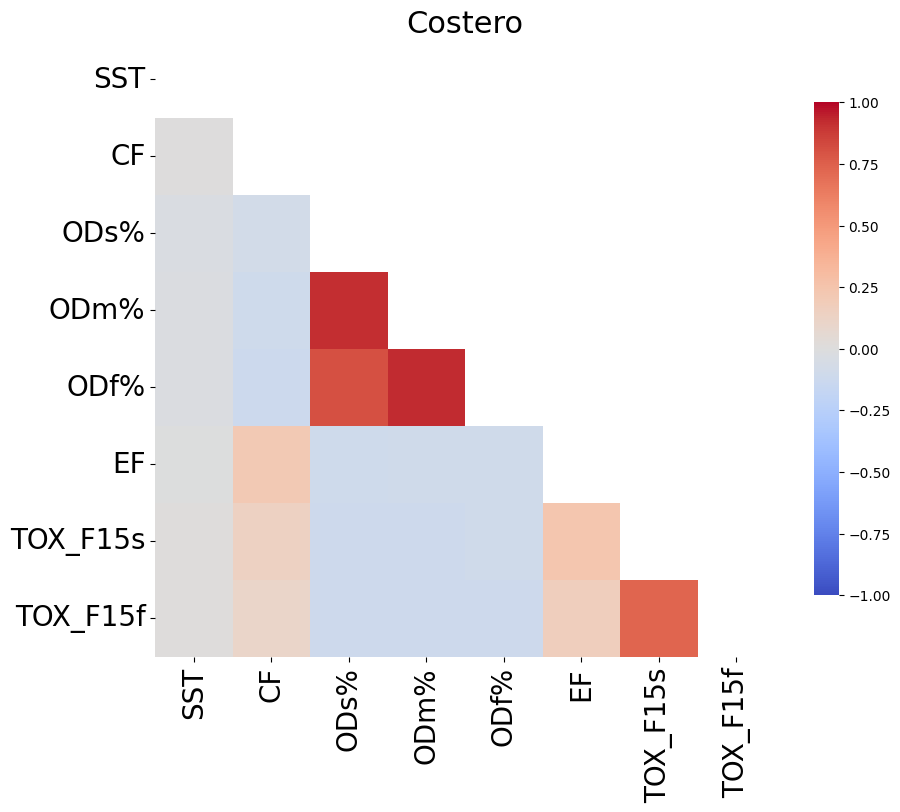

In [88]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero', fontsize=22)

# Mostrar el gráfico
plt.show()

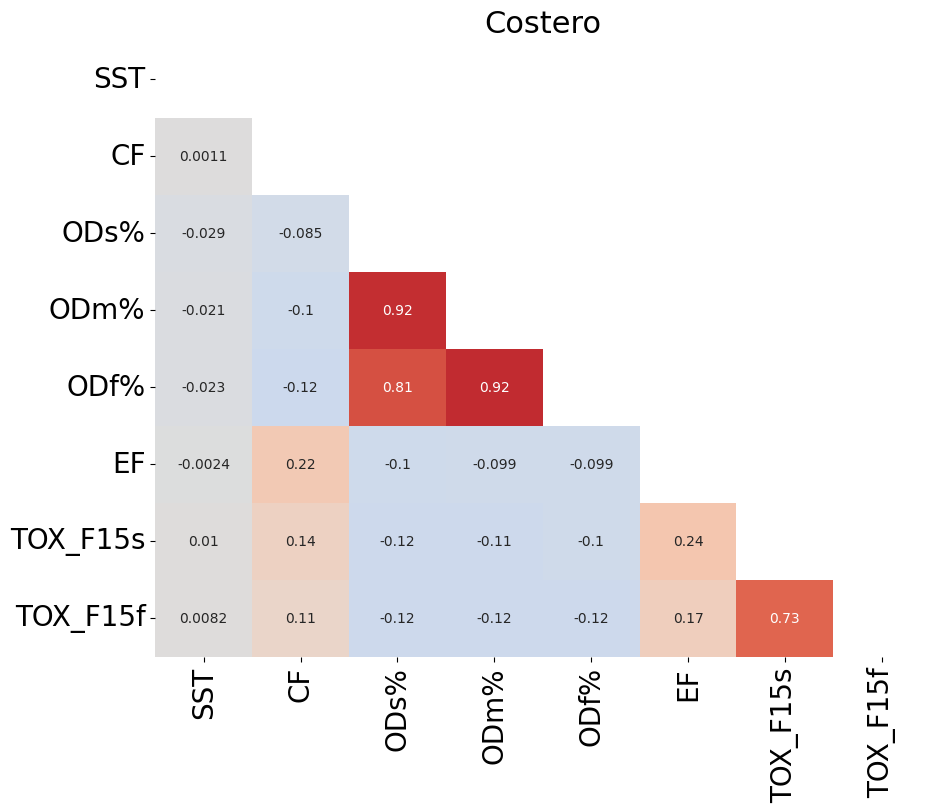

In [89]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero', fontsize=22)

# Mostrar el gráfico
plt.show()

#####Coeficiente de correlación de Spearman

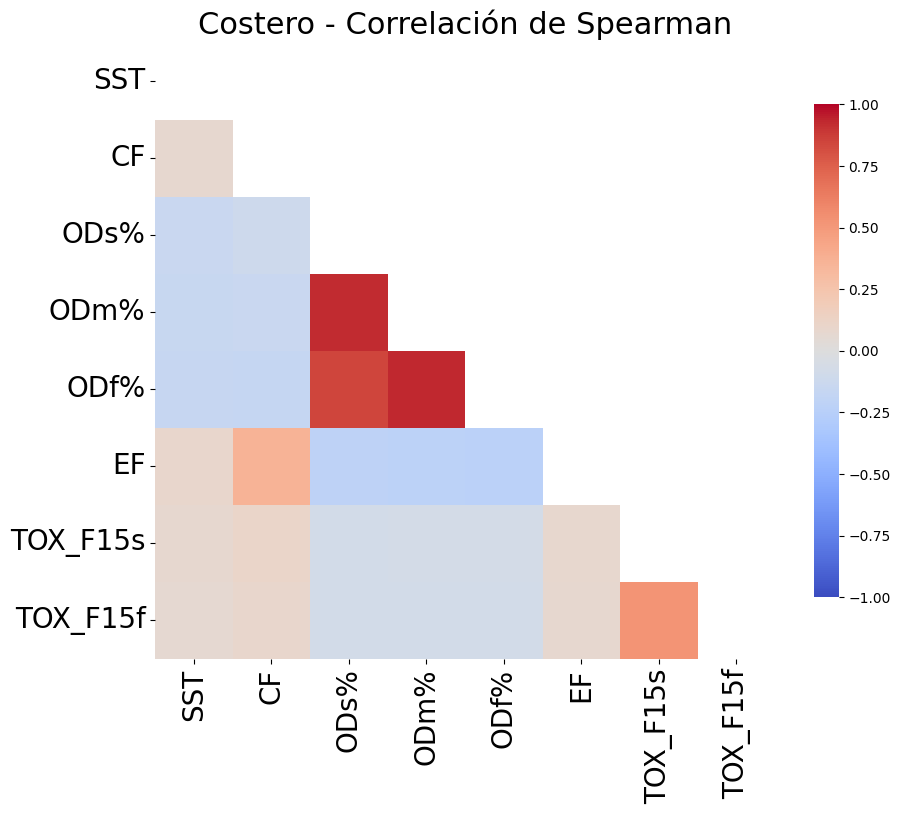

In [90]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


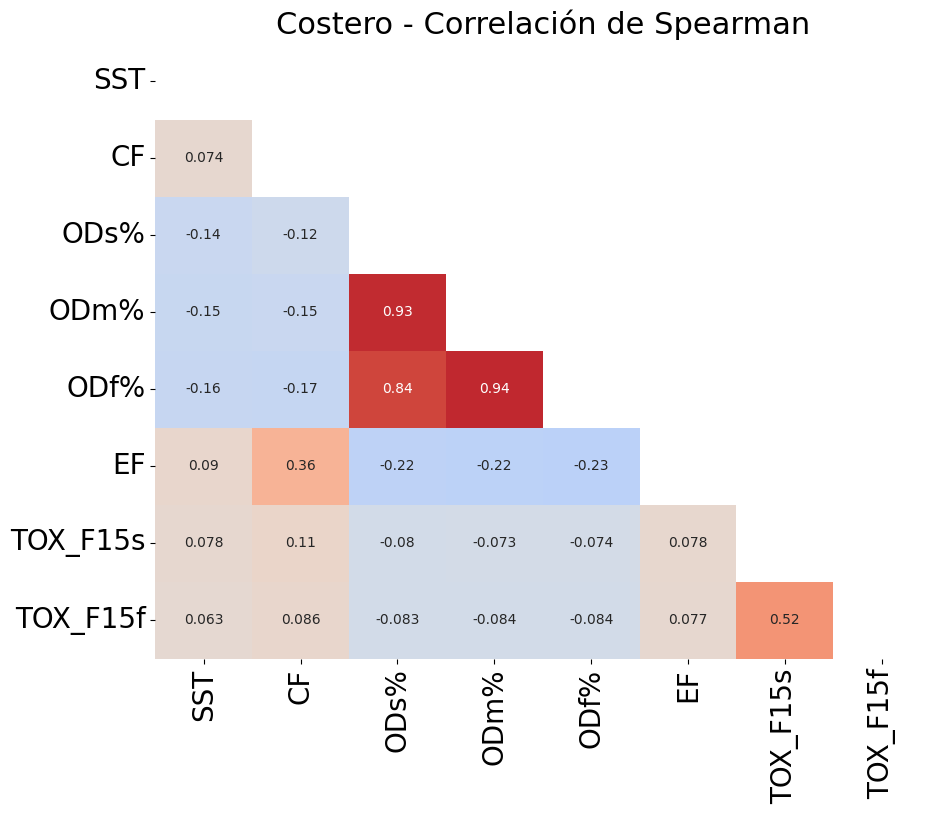

In [91]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Costero - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


###Mapa de calor de correlacion entre variables independientes y variable objetivo

####al 2021

Matriz de coeficientes Eta:
       Water quality
TSS         0.179576
FC          0.433037
ODs%        0.135652
ODm%        0.152005
ODb%        0.182879
FE          0.497867
TF15s       0.117152
TF15b       0.151836


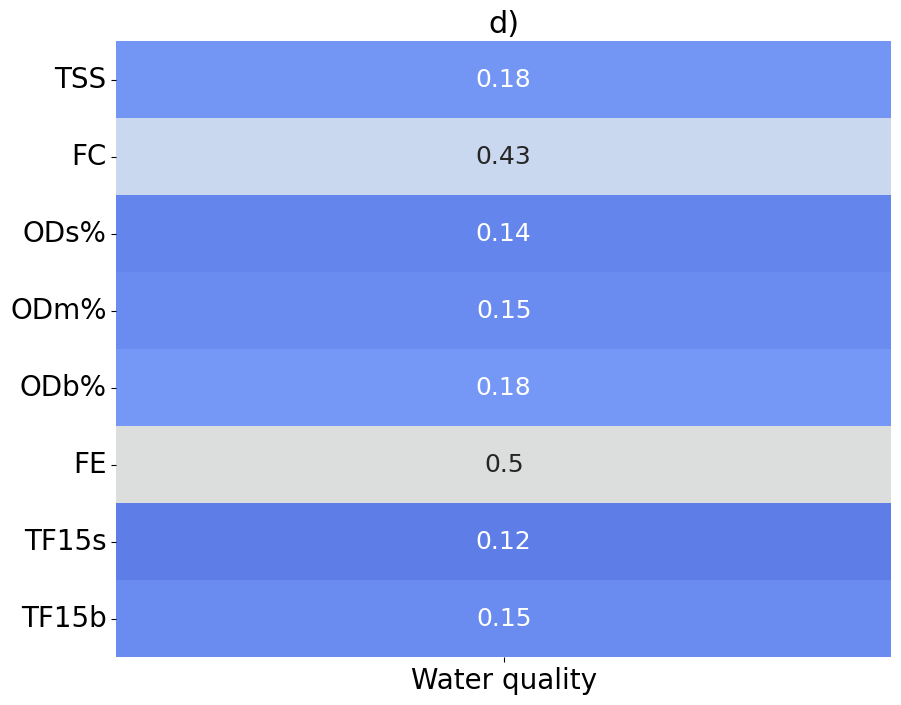

In [92]:
# Función para calcular el coeficiente Eta
def coeficiente_eta(categorica, numerica):
    categorias = categorica.unique()
    medias_grupo = numerica.groupby(categorica).mean()
    media_total = numerica.mean()

    # Suma de cuadrados entre grupos
    ss_between = sum(categorica.value_counts()[cat] * (medias_grupo[cat] - media_total)**2 for cat in categorias)
    # Suma de cuadrados totales
    ss_total = sum((numerica - media_total)**2)

    # Coeficiente Eta
    eta = np.sqrt(ss_between / ss_total)
    return eta

# Función para calcular y graficar el mapa de calor del coeficiente Eta
def graficar_coeficiente_eta(df, variable_categorica, variables_numericas, nombres_mostrados=None):
    # Si se proporcionan nombres renombrados, construir un diccionario para mapear
    if nombres_mostrados:
        nombres_dict = dict(zip(variables_numericas, nombres_mostrados))
    else:
        nombres_dict = {col: col for col in variables_numericas}  # Mismos nombres si no se proporcionan nuevos

    # Crear una matriz de coeficientes Eta
    eta_matrix = pd.DataFrame(index=nombres_mostrados if nombres_mostrados else variables_numericas,
                              columns=["Water quality"])  # Cambiar el título de la columna a "Water quality"

    for var in variables_numericas:
        eta_matrix.loc[nombres_dict[var], "Water quality"] = coeficiente_eta(df[variable_categorica], df[var])

    # Convertir a tipo float para visualización
    eta_matrix = eta_matrix.astype(float)

    # Imprimir los valores calculados
    print("Matriz de coeficientes Eta:")
    print(eta_matrix)

    # Crear un mapa de calor
    plt.figure(figsize=(10, 8))
    # Aumentar el tamaño de la letra de las anotaciones
    sns.heatmap(eta_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar=False, cbar_kws={'shrink': 0.8},
                annot_kws={'size': 18})  # Puedes cambiar el valor de 'size' para hacer el texto más grande

    # Personalización del gráfico
    plt.title('d)', fontsize=22)
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.xlabel("", fontsize=20)  # Cambiar etiqueta del eje x
    plt.show()

    # Ejemplo de uso con nombres personalizados:
graficar_coeficiente_eta(
    df=df_costero_calidad_del_agua_2021,
    variable_categorica='Calidad del agua',
    variables_numericas=['SST', 'CF', 'ODs%', 'ODm%', 'ODf%', 'EF', 'TOX_F15s','TOX_F15f',],
    nombres_mostrados=['TSS', 'FC', 'ODs%', 'ODm%', 'ODb%', 'FE', 'TF15s', 'TF15b']
)


Matriz de coeficientes Eta:
       Calidad del agua
TSS            0.179576
FC             0.433037
ODs%           0.135652
ODm%           0.152005
ODb%           0.182879
FE             0.497867
TF15s          0.117152
TF15b          0.151836


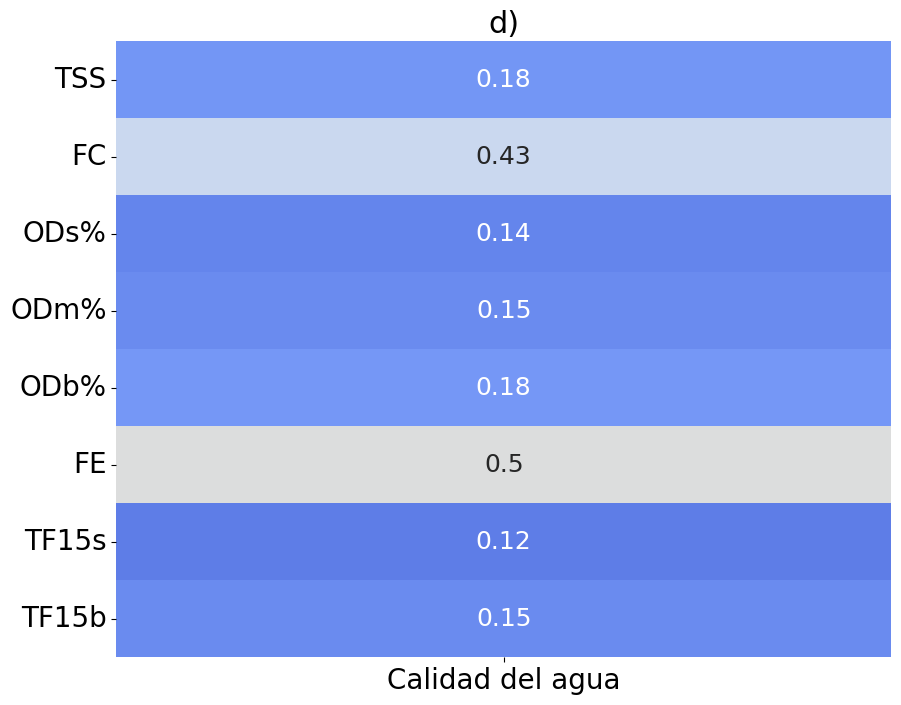

In [93]:
# Función para calcular el coeficiente Eta
def coeficiente_eta(categorica, numerica):
    categorias = categorica.unique()
    medias_grupo = numerica.groupby(categorica).mean()
    media_total = numerica.mean()

    # Suma de cuadrados entre grupos
    ss_between = sum(categorica.value_counts()[cat] * (medias_grupo[cat] - media_total)**2 for cat in categorias)
    # Suma de cuadrados totales
    ss_total = sum((numerica - media_total)**2)

    # Coeficiente Eta
    eta = np.sqrt(ss_between / ss_total)
    return eta

# Función para calcular y graficar el mapa de calor del coeficiente Eta
def graficar_coeficiente_eta(df, variable_categorica, variables_numericas, nombres_mostrados=None):
    # Si se proporcionan nombres renombrados, construir un diccionario para mapear
    if nombres_mostrados:
        nombres_dict = dict(zip(variables_numericas, nombres_mostrados))
    else:
        nombres_dict = {col: col for col in variables_numericas}  # Mismos nombres si no se proporcionan nuevos

    # Crear una matriz de coeficientes Eta
    eta_matrix = pd.DataFrame(index=nombres_mostrados if nombres_mostrados else variables_numericas,
                              columns=[variable_categorica])

    for var in variables_numericas:
        eta_matrix.loc[nombres_dict[var], variable_categorica] = coeficiente_eta(df[variable_categorica], df[var])

    # Convertir a tipo float para visualización
    eta_matrix = eta_matrix.astype(float)

    # Imprimir los valores calculados
    print("Matriz de coeficientes Eta:")
    print(eta_matrix)

    # Crear un mapa de calor
    plt.figure(figsize=(10, 8))
    # Aumentar el tamaño de la letra de las anotaciones
    sns.heatmap(eta_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar=False, cbar_kws={'shrink': 0.8},
                annot_kws={'size': 18})  # Puedes cambiar el valor de 'size' para hacer el texto más grande

    # Personalización del gráfico
    plt.title('d)', fontsize=22)
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.show()

# Ejemplo de uso con nombres personalizados:
graficar_coeficiente_eta(
    df=df_costero_calidad_del_agua_2021,
    variable_categorica='Calidad del agua',
    variables_numericas=['SST', 'CF', 'ODs%', 'ODm%', 'ODf%', 'EF', 'TOX_F15s','TOX_F15f',],
    nombres_mostrados=['TSS', 'FC', 'ODs%', 'ODm%', 'ODb%', 'FE', 'TF15s', 'TF15b']
)


####al 2022

####al 2023

##Template

In [94]:
costero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23456 entries, 0 to 23455
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          23456 non-null  object 
 1   CLAVE MONITOREO      23456 non-null  object 
 2   NOMBRE DEL SITIO     23456 non-null  object 
 3   TIPO CUERPO DE AGUA  23456 non-null  object 
 4   FECHA REALIZACIÓN    23456 non-null  object 
 5   AÑO                  23456 non-null  object 
 6   SST                  23290 non-null  float64
 7   CF                   22430 non-null  float64
 8   ODs%                 22357 non-null  float64
 9   ODm%                 9040 non-null   float64
 10  ODf%                 7440 non-null   float64
 11  EF                   23137 non-null  float64
 12  TOX_F15s             23181 non-null  float64
 13  TOX_F15f             14857 non-null  float64
dtypes: float64(8), object(6)
memory usage: 2.5+ MB


In [95]:
costero_template = costero.copy()

In [96]:
# Filtrar el DataFrame original para que solo incluya las filas donde el año es 2022
costero_template = costero[costero['AÑO'].isin([2022])]

In [97]:
costero_template = costero_template.reset_index(drop=True)

In [98]:
# Reemplazar los caracteres específicos en las columnas seleccionadas
columns = ['SST', 'CF', 'ODs%', 'ODm%', 'ODf%', 'EF', 'TOX_F15s', 'TOX_F15f']  # Asegúrate de ajustar 'columns' según tus necesidades

# Usar .loc para evitar el SettingWithCopyWarning
costero_template.loc[:, columns] = costero_template[columns].replace({'<':'', '>':'', '≤':'', '≥':''}, regex=True)


In [99]:
costero_template.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          222 non-null    object 
 1   CLAVE MONITOREO      222 non-null    object 
 2   NOMBRE DEL SITIO     222 non-null    object 
 3   TIPO CUERPO DE AGUA  222 non-null    object 
 4   FECHA REALIZACIÓN    222 non-null    object 
 5   AÑO                  222 non-null    object 
 6   SST                  192 non-null    float64
 7   CF                   195 non-null    float64
 8   ODs%                 190 non-null    float64
 9   ODm%                 25 non-null     float64
 10  ODf%                 100 non-null    float64
 11  EF                   212 non-null    float64
 12  TOX_F15s             167 non-null    float64
 13  TOX_F15f             97 non-null     float64
dtypes: float64(8), object(6)
memory usage: 24.4+ KB


In [100]:
# Eliminar filas con valores nulos en las columnas 'Alk', 'Cond' y 'Hard'
costero_template = costero_template.dropna(subset=['SST', 'CF', 'ODs%', 'ODm%', 'ODf%', 'EF', 'TOX_F15s', 'TOX_F15f'])

In [101]:
costero_template.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 11 to 163
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          21 non-null     object 
 1   CLAVE MONITOREO      21 non-null     object 
 2   NOMBRE DEL SITIO     21 non-null     object 
 3   TIPO CUERPO DE AGUA  21 non-null     object 
 4   FECHA REALIZACIÓN    21 non-null     object 
 5   AÑO                  21 non-null     object 
 6   SST                  21 non-null     float64
 7   CF                   21 non-null     float64
 8   ODs%                 21 non-null     float64
 9   ODm%                 21 non-null     float64
 10  ODf%                 21 non-null     float64
 11  EF                   21 non-null     float64
 12  TOX_F15s             21 non-null     float64
 13  TOX_F15f             21 non-null     float64
dtypes: float64(8), object(6)
memory usage: 2.5+ KB


In [102]:
costero_template.to_csv("costero_template.csv")

##Model training

#####Separación de los datos en conjuntos de entrenamiento y prueba

In [103]:
# Crea un nuevo DataFrame para el entrenamiento del modelo con datos desde 2012 hasta 2021, excluyendo los años 2022 y 2023
train_coastal = data_costero[(data_costero['AÑO'] != 2022) & (data_costero['AÑO'] != 2023)]

# Crea un nuevo DataFrame para validación que consiste únicamente en datos de los años 2022 y 2023
val_coastal = data_costero[(data_costero['AÑO'] == 2022) | (data_costero['AÑO'] == 2023)]

In [104]:
# Selecciona columnas para el entrenamiento del modelo, incluyendo las columnas de contaminantes y la variable objetivo 'Calidad del agua' para el conjunto de datos de 2012 a 2021
train_coastal_num = train_coastal.iloc[:, list(range(6, 14)) + [30]]
train_coastal_num.head()

,SST,CF,ODs%,ODm%,ODf%,EF,TOX_F15s,TOX_F15f,Calidad del agua
0,10.00,3.0,90.1,89.50,95.1,10.0,1.0,1.0,0
3,10.25,75.0,103.7,100.20,100.2,1.0,1.0,1.0,0
4,10.00,1.0,89.5,92.01,93.0,1.0,1.0,1.0,0
5,21.25,265.0,105.8,105.90,105.8,10.0,1.0,1.0,0
6,13.00,41.0,109.3,107.20,105.1,1.0,1.0,1.0,0


In [105]:
# Muestra el tamaño del DataFrame de entrenamiento
train_coastal_num.shape

(5319, 9)

In [106]:
# Selecciona columnas para el entrenamiento del modelo, incluyendo las columnas de contaminantes y la variable objetivo 'Calidad del agua' para el conjunto de datos del año 2022
val_coastal_num = val_coastal.iloc[:, list(range(6, 14)) + [30]]
val_coastal_num.head()

,SST,CF,ODs%,ODm%,ODf%,EF,TOX_F15s,TOX_F15f,Calidad del agua
23245,10.0,1500.0,74.1,56.8,34.8,10.0,1.0,1.0,1
23250,40.2,63.0,83.4,72.7,65.0,10.0,1.0,1.0,0
23253,34.4,393.0,78.7,66.9,56.7,10.0,1.0,1.0,0
23257,40.0,295.0,74.4,65.5,57.2,10.0,1.0,1.0,0
23261,22.3,279.0,85.4,78.6,65.1,10.0,1.0,1.0,0


In [107]:
# Muestra el tamaño del DataFrame de validación
val_coastal_num.shape

(21, 9)

Separación de la variable dependiente (y) de las variables independientes (X)

In [108]:
# Separa las características (X_val_costero) y la variable objetivo (y_val_costero) para la validación
X_train_coastal_num = train_coastal_num.drop(columns=['Calidad del agua'])
y_train_coastal_num = train_coastal_num['Calidad del agua']

In [109]:
# Separa las características (X_val_costero) y la variable objetivo (y_val_costero) para la validación
X_val_coastal_num = val_coastal_num.drop(columns=['Calidad del agua'])
y_val_coastal_num = val_coastal_num['Calidad del agua']

In [110]:
X_train_coastal_num.shape, y_train_coastal_num.shape, X_val_coastal_num.shape, y_val_coastal_num.shape,

((5319, 8), (5319,), (21, 8), (21,))

In [111]:
# Guardar el conjunto de entrenamiento en un archivo Excel
#X_train_coastal.to_excel("train_data_ub_coastal.xlsx", index=False)
#y_train_coastal.to_excel("train_labels_data_ub_coastal.xlsx", index=False)

# Guardar el conjunto de prueba en un archivo Excel
#X_ub_num_test_coastal.to_excel("test_data_ub_coastal.xlsx", index=False)
#y_ub_num_test_coastal.to_excel("test_labels_data_ub_coastal.xlsx", index=False)

In [112]:
# Calcula el conteo de clases presentes en la columna 'Water quality'
conteo_clases = train_coastal_num['Calidad del agua'].value_counts()

# Imprime el conteo de clases
print(conteo_clases)

Calidad del agua
0    3882
1    1003
2     434
Name: count, dtype: int64


In [113]:
# Calcula el conteo de clases presentes en la columna 'Water quality' del conjunto de validación
conteo_clases = val_coastal_num['Calidad del agua'].value_counts()

# Imprime el conteo de clases
print(conteo_clases)

Calidad del agua
0    16
1     5
Name: count, dtype: int64


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_train_coastal_num, y_train_coastal_num, test_size= 0.2, random_state=42)

In [115]:
# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###Con grid search y cross validation

####Unbalanced classes

#####XGBOOST

In [116]:
# Define a dictionary of hyperparameters for tuning a XGBoost model
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_xgb = XGBClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_xgb, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_xgb.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}, Accuracy: 0.9971804511278195, Best score (cv): 0.9938895417156287
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimato

######Metrics

 Evaluate the model on the training set

In [117]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9988249118683902
Precision:  0.9988265143511595
Precision per class: [0.99935588 0.99626866 1.        ]
Recall:  0.9988249118683902
Recall per class: [0.99903413 0.99875312 0.99711816]
F1 Score:  0.9988252330546723
F1-score for the class 0: 0.999194976654323
F1-score for the class 1: 0.9975093399750934
F1-score for the class 2: 0.9985569985569985
jaccard: 0.9976540832750918
Confusion Matrix: 
[[3103    3    0]
 [   1  801    0]
 [   1    0  346]]


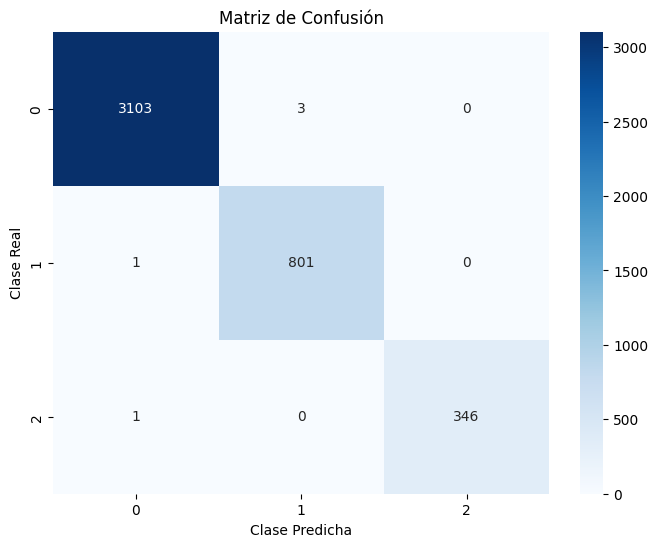

In [118]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [119]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9971804511278195
Precision:  0.9971781710550508
Precision per class: [0.997426 0.995    1.      ]
Recall:  0.9971804511278195
Recall per class: [0.99871134 0.99004975 1.        ]
F1 Score:  0.9971778432557572
F1-score for the class 0: 0.9980682549903412
F1-score for the class 1: 0.9925187032418953
F1-score for the class 2: 1.0
jaccard: 0.9976540832750918
Confusion Matrix: 
[[775   1   0]
 [  2 199   0]
 [  0   0  87]]


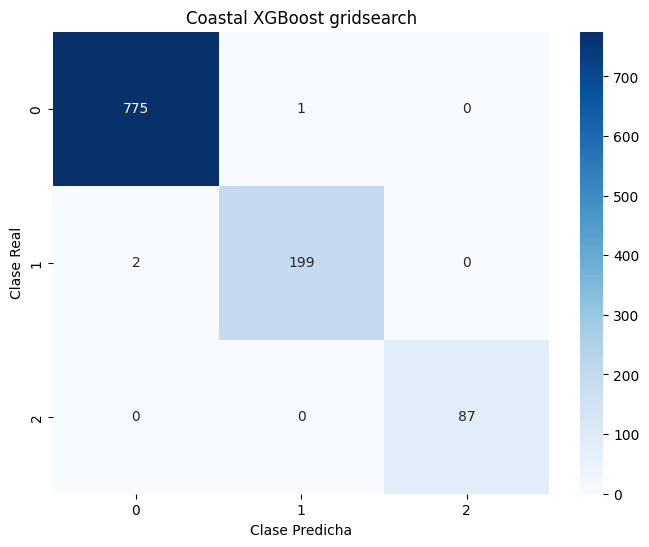

In [120]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal XGBoost gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [121]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


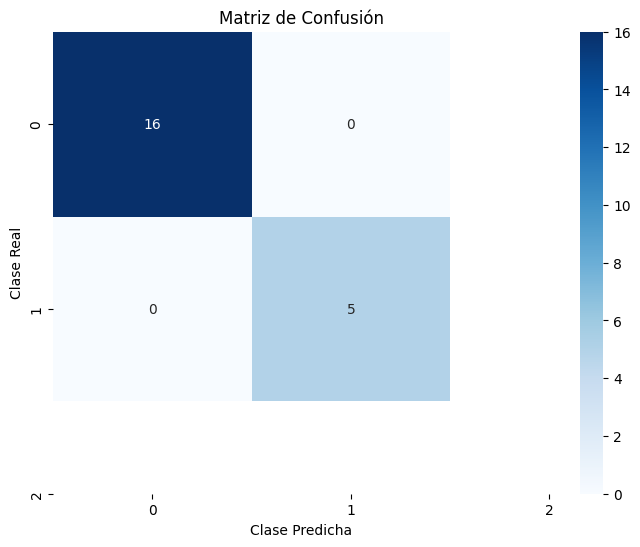

In [122]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

#####SVM

In [123]:
# Define a dictionary of hyperparameters for tuning a SVM model
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_svm = SVC()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_svm, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_svm_bin.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}, Accuracy: 0.9624060150375939, Best score (cv): 0.9623971797884842
Best model: SVC(C=10, gamma='auto')
Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.9623971797884842


######Metrics

 Evaluate the model on the training set

In [124]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9699177438307873
Precision:  0.9703700778146039
Precision per class: [0.97382529 0.94416873 1.        ]
Recall:  0.9699177438307873
Recall per class: [0.99420476 0.94887781 0.80115274]
F1 Score:  0.9691706477249029
F1-score for the class 0: 0.9839095109128565
F1-score for the class 1: 0.9465174129353234
F1-score for the class 2: 0.8896
jaccard: 0.9415270954251913
Confusion Matrix: 
[[3088   18    0]
 [  41  761    0]
 [  42   27  278]]


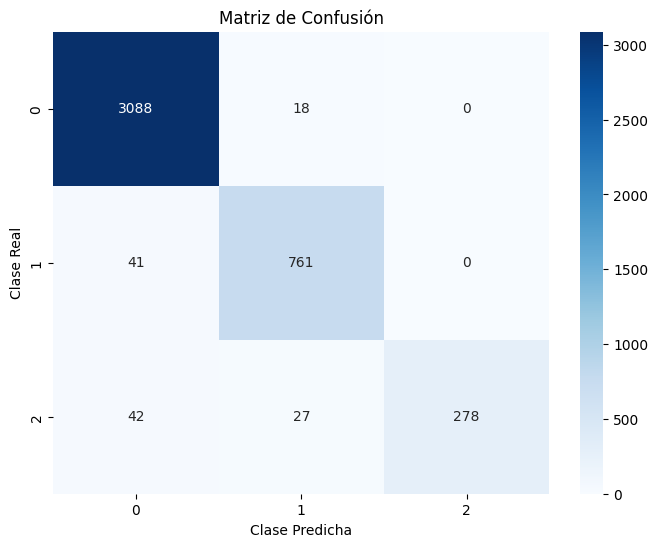

In [125]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [126]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9624060150375939
Precision:  0.9631150149807105
Precision per class: [0.96737767 0.93069307 1.        ]
Recall:  0.9624060150375939
Recall per class: [0.9935567  0.93532338 0.74712644]
F1 Score:  0.9611356418518322
F1-score for the class 0: 0.9802924348378894
F1-score for the class 1: 0.9330024813895782
F1-score for the class 2: 0.8552631578947368
jaccard: 0.9415270954251913
Confusion Matrix: 
[[771   5   0]
 [ 13 188   0]
 [ 13   9  65]]


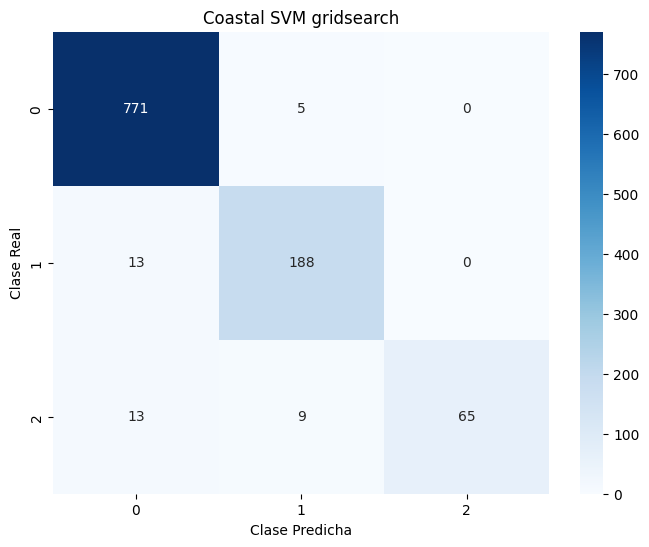

In [127]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal SVM gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [128]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


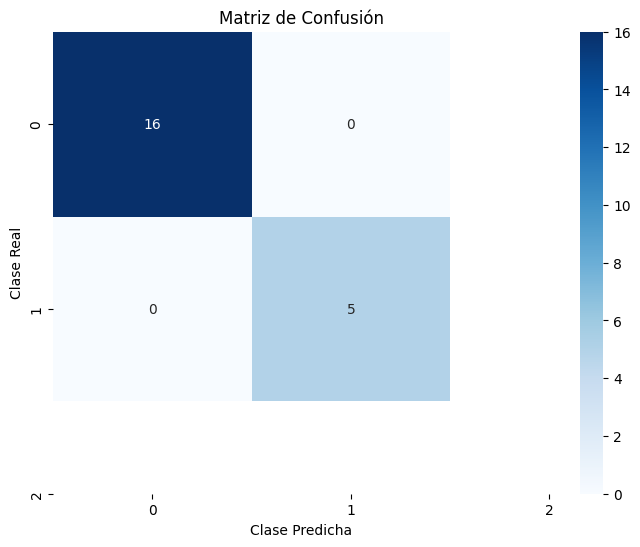

In [129]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

#####KNN

In [130]:
# Define a dictionary of hyperparameters for tuning a KNN model
parameters = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de ponderación
    'p': [1, 2]  # Parámetro para la distancia (1 para la distancia de Manhattan, 2 para la Euclidiana)
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_knn = KNeighborsClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_knn, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_knn_bin.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, Accuracy: 0.9351503759398496, Best score (cv): 0.9381903642773206
Best model: KNeighborsClassifier(n_neighbors=3, weights='distance')
Best params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best score: 0.9381903642773206


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


######Metrics

 Evaluate the model on the training set

In [131]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[3106    0    0]
 [   0  802    0]
 [   0    0  347]]


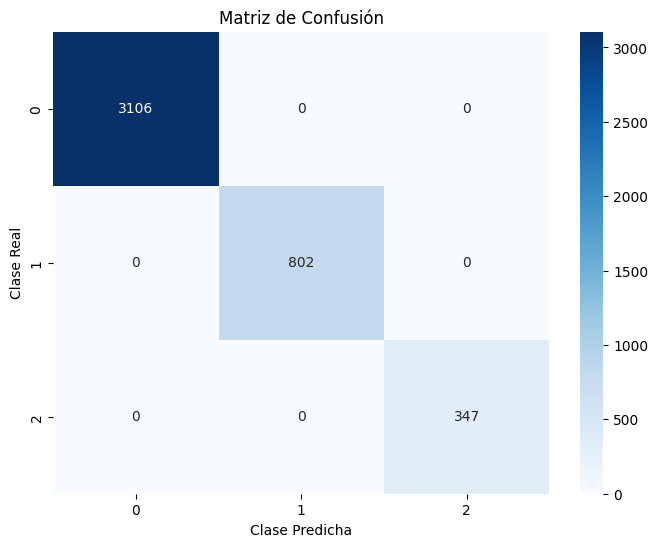

In [132]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [133]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9351503759398496
Precision:  0.9370840363768624
Precision per class: [0.95380774 0.85377358 0.98039216]
Recall:  0.9351503759398496
Recall per class: [0.98453608 0.90049751 0.57471264]
F1 Score:  0.9314953484063278
F1-score for the class 0: 0.9689283449587826
F1-score for the class 1: 0.8765133171912833
F1-score for the class 2: 0.7246376811594203
jaccard: 1.0
Confusion Matrix: 
[[764  11   1]
 [ 20 181   0]
 [ 17  20  50]]


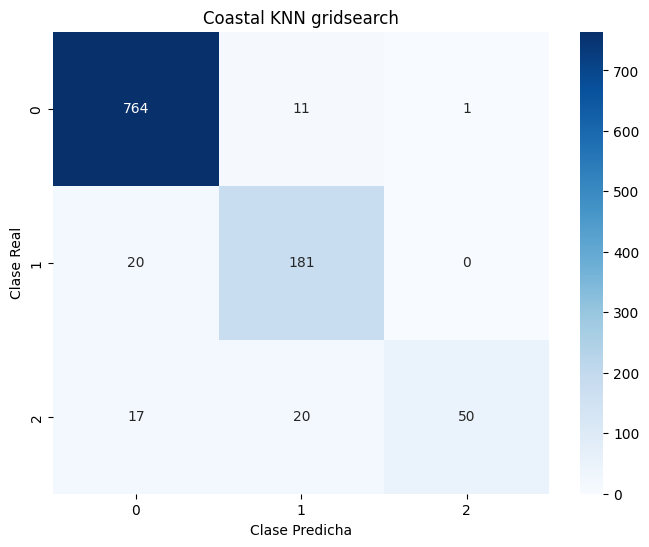

In [134]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal KNN gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [135]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9047619047619048
Precision:  0.9551820728291316
Precision per class: [0.94117647 1.         0.        ]
Recall:  0.9047619047619048
Recall per class: [1.  0.6 0. ]
F1 Score:  0.9173881673881674
F1-score for the class 0: 0.9696969696969697
F1-score for the class 1: 0.75
F1-score for the class 2: 0.0
jaccard: 0.8599439775910364
Confusion Matrix: 
[[16  0  0]
 [ 1  3  1]
 [ 0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


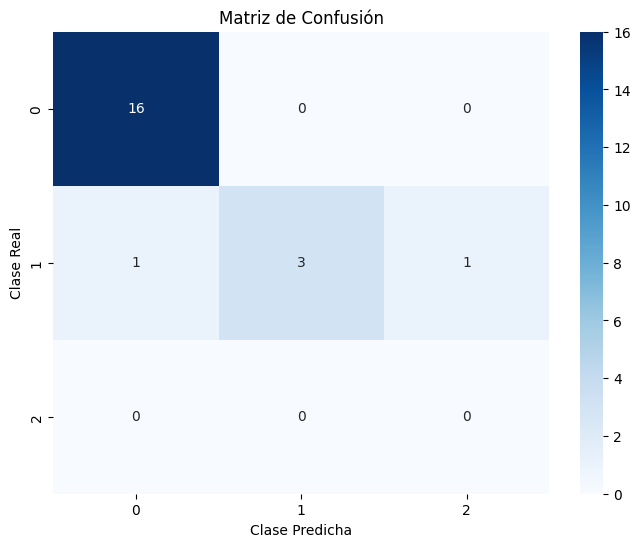

In [136]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

#####DT

In [137]:
# Define a dictionary of hyperparameters for tuning a DT model
parameters = {
    'criterion': ['gini', 'entropy'],  # Criterio para la división de nodos
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en una hoja
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_dt = DecisionTreeClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_dt, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_dt.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}, Accuracy: 0.9981203007518797, Best score (cv): 0.9981198589894242
Best model: DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
Best params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score: 0.9981198589894242


######Metrics

 Evaluate the model on the training set

In [138]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[3106    0    0]
 [   0  802    0]
 [   0    0  347]]


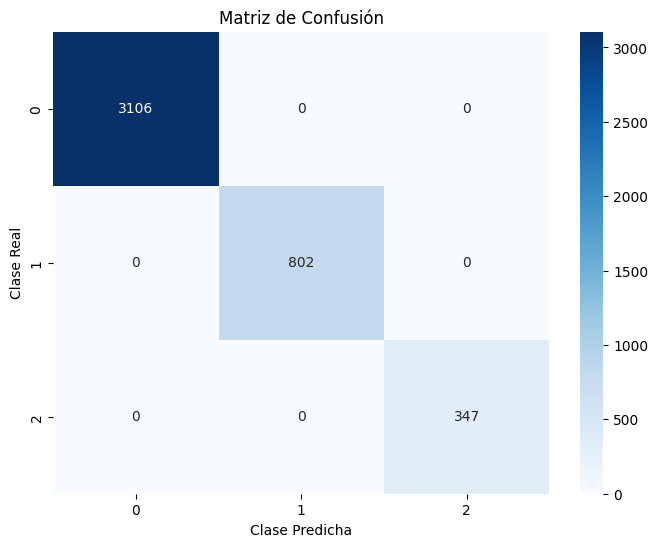

In [139]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [140]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9981203007518797
Precision:  0.9981251328836228
Precision per class: [0.99742931 1.         1.        ]
Recall:  0.9981203007518797
Recall per class: [1.         0.99004975 1.        ]
F1 Score:  0.998116811091435
F1-score for the class 0: 0.9987129987129987
F1-score for the class 1: 0.995
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[776   0   0]
 [  2 199   0]
 [  0   0  87]]


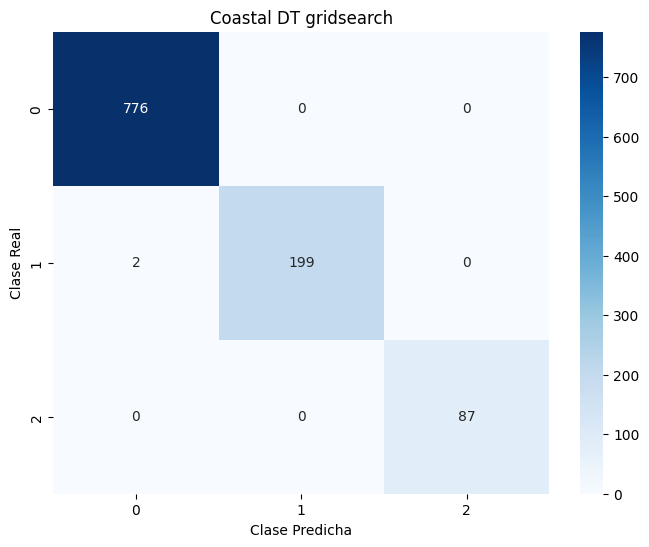

In [141]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal DT gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [142]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


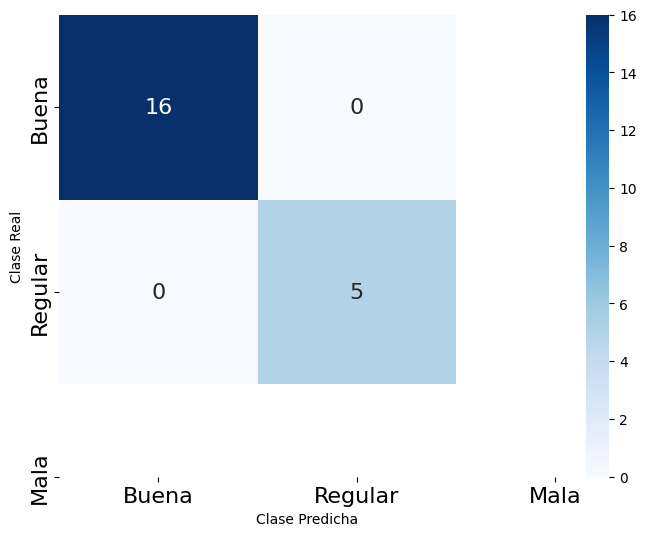

In [143]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####MLR

In [144]:
# Define a dictionary of hyperparameters for tuning a MLR model
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Método de optimización
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_mlr = LogisticRegression(max_iter=1000)  # Usamos max_iter para evitar advertencias

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_mlr, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_mlr.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best params: {'C': 100, 'solver': 'newton-cg'}, Accuracy: 0.9492481203007519, Best score (cv): 0.9473560517038779
Best model: LogisticRegression(C=100, max_iter=1000, solver='newton-cg')
Best params: {'C': 100, 'solver': 'newton-cg'}
Best score: 0.9473560517038779


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


######Metrics

Evaluate the model on the training set

In [145]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9487661574618096
Precision:  0.9485848916750453
Precision per class: [0.94744977 0.93961708 0.97947214]
Recall:  0.9487661574618096
Recall per class: [0.98679974 0.79551122 0.96253602]
F1 Score:  0.9472494081862662
F1-score for the class 0: 0.9667244914051412
F1-score for the class 1: 0.861580013504389
F1-score for the class 2: 0.9709302325581395
jaccard: 0.902541751512293
Confusion Matrix: 
[[3065   38    3]
 [ 160  638    4]
 [  10    3  334]]


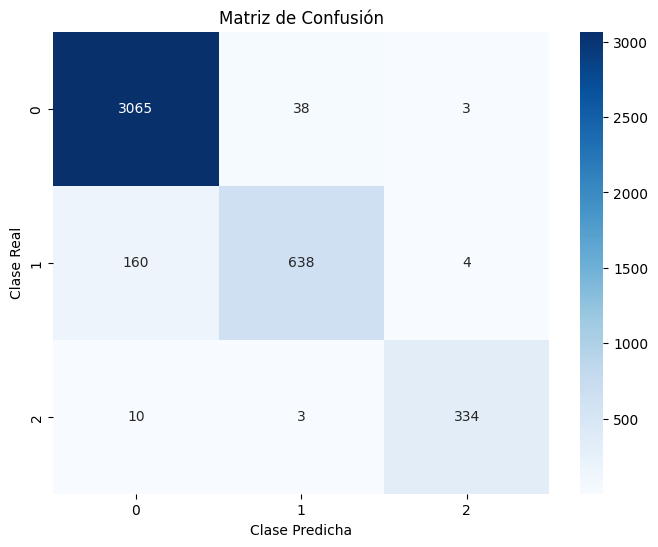

In [146]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [147]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9492481203007519
Precision:  0.9489521431179756
Precision per class: [0.95043371 0.93678161 0.96385542]
Recall:  0.9492481203007519
Recall per class: [0.98840206 0.81094527 0.91954023]
F1 Score:  0.9479305809766138
F1-score for the class 0: 0.969046114971573
F1-score for the class 1: 0.8693333333333333
F1-score for the class 2: 0.9411764705882353
jaccard: 0.902541751512293
Confusion Matrix: 
[[767   9   0]
 [ 35 163   3]
 [  5   2  80]]


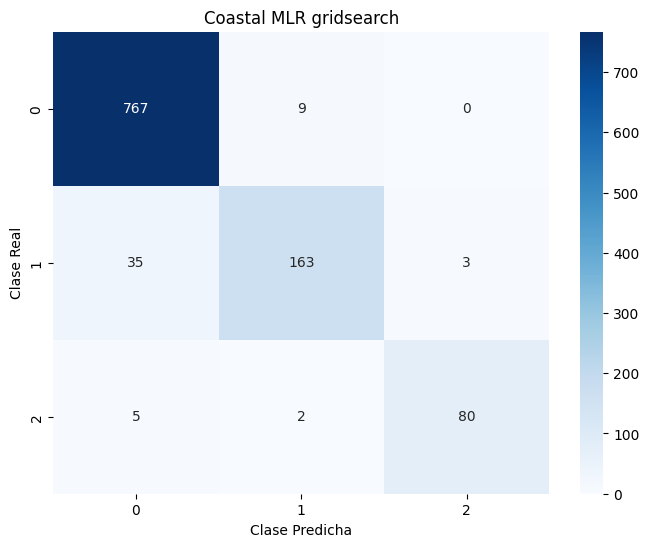

In [148]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal MLR gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [149]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


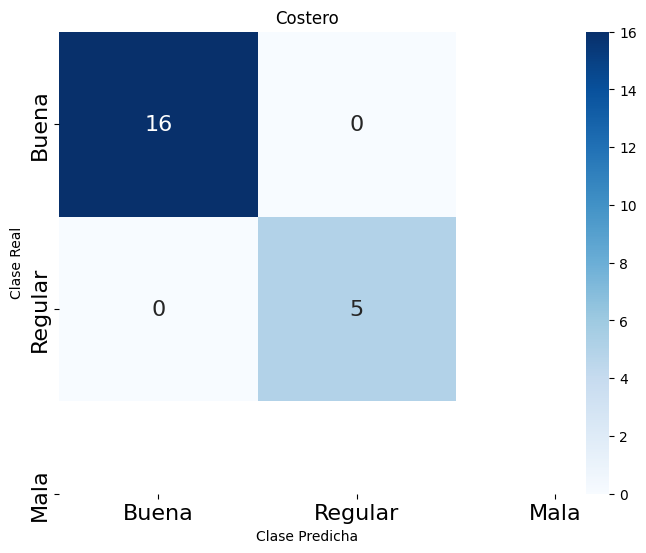

In [150]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Costero')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


####Balanced classes

#####Separation of data into training and test sets

Apply random subsampling

In [151]:
print('Before class balancing: ', Counter(y_train_coastal_num))
print("")
rus = RandomUnderSampler(random_state=42)
X_train_coastal_num, y_train_coastal_num = rus.fit_resample(X_train_coastal_num, y_train_coastal_num)
print('After the balancing y:', Counter(y_train_coastal_num))
print("")
print('After the balancing X:', Counter(X_train_coastal_num))

Before class balancing:  Counter({0: 3882, 1: 1003, 2: 434})

After the balancing y: Counter({0: 434, 1: 434, 2: 434})

After the balancing X: Counter({'SST': 1, 'CF': 1, 'ODs%': 1, 'ODm%': 1, 'ODf%': 1, 'EF': 1, 'TOX_F15s': 1, 'TOX_F15f': 1})


In [152]:
# Guardar el conjunto de entrenamiento en un archivo Excel
#X_train_b_coa.to_excel("train_data_b_coa.xlsx", index=False)
#y_train_b_coa.to_excel("train_labels_data_b_coa.xlsx", index=False)

# Guardar el conjunto de prueba en un archivo Excel
#X_test_b_coa.to_excel("test_data_b_coa.xlsx", index=False)
#y_test_b_coa.to_excel("test_labels_data_b_coa.xlsx", index=False)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_train_coastal_num, y_train_coastal_num, test_size= 0.2, random_state=42)

In [154]:
# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [155]:
X_train.shape, X_test.shape

((1041, 8), (261, 8))

#####XGBOOST

In [156]:
# Define a dictionary of hyperparameters for tuning a XGBoost model
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_xgb = XGBClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_xgb, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_xgb.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}, Accuracy: 0.9923371647509579, Best score (cv): 0.9846337872653663
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators'

######Metrics

 Evaluate the model on the training set

In [157]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[343   0   0]
 [  0 347   0]
 [  0   0 351]]


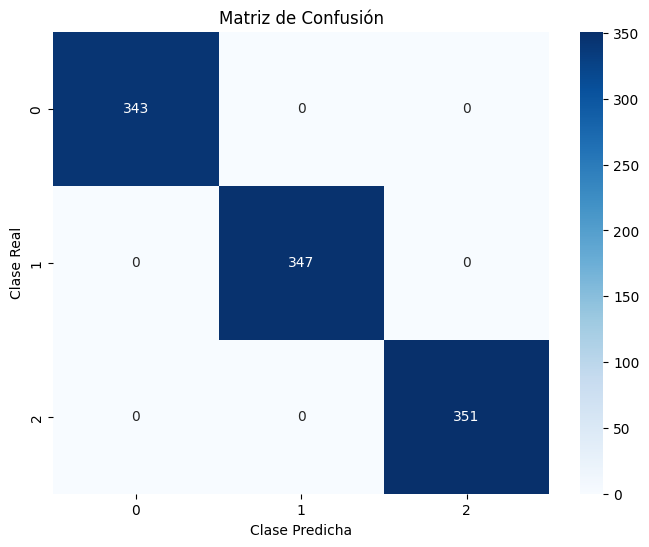

In [158]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [159]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9923371647509579
Precision:  0.9924244227092802
Precision per class: [0.98913043 1.         0.98809524]
Recall:  0.9923371647509579
Recall per class: [1.         0.97701149 1.        ]
F1 Score:  0.9923145530476492
F1-score for the class 0: 0.994535519125683
F1-score for the class 1: 0.9883720930232558
F1-score for the class 2: 0.9940119760479041
jaccard: 1.0
Confusion Matrix: 
[[91  0  0]
 [ 1 85  1]
 [ 0  0 83]]


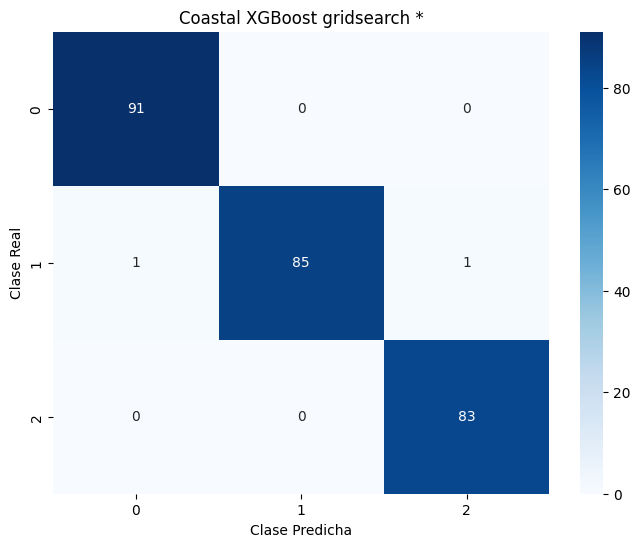

In [160]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal XGBoost gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [161]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


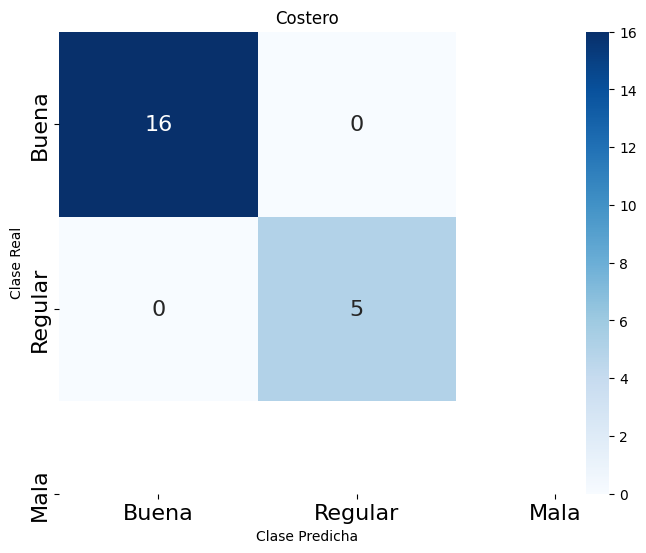

In [162]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Costero')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####SVM

In [163]:
# Define a dictionary of hyperparameters for tuning a SVM model
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_svm = SVC()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_svm, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_svm.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}, Accuracy: 0.896551724137931, Best score (cv): 0.927972027972028
Best model: SVC(C=10, gamma=0.1, kernel='linear')
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Best score: 0.927972027972028


######Metrics

 Evaluate the model on the training set

In [164]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9346781940441883
Precision:  0.9369212550530382
Precision per class: [0.872      0.94871795 0.98870056]
Recall:  0.9346781940441883
Recall per class: [0.95335277 0.85302594 0.997151  ]
F1 Score:  0.9343492903133895
F1-score for the class 0: 0.9108635097493036
F1-score for the class 1: 0.8983308042488619
F1-score for the class 2: 0.9929078014184397
jaccard: 0.8797947008317505
Confusion Matrix: 
[[327  15   1]
 [ 48 296   3]
 [  0   1 350]]


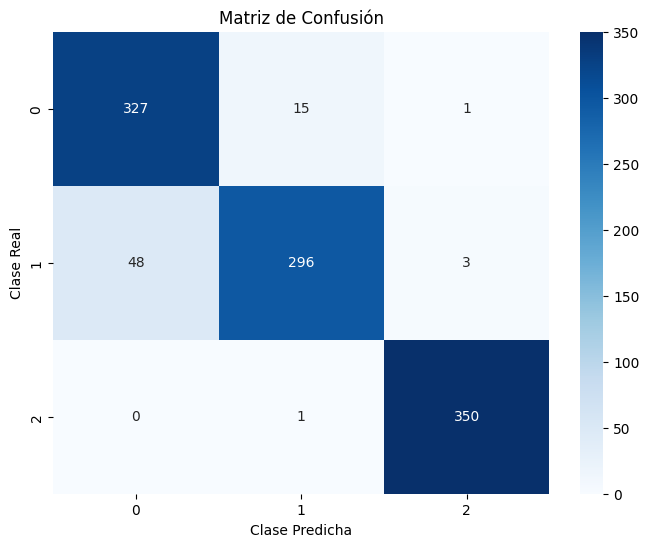

In [165]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [166]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.896551724137931
Precision:  0.901559934318555
Precision per class: [0.81904762 0.91666667 0.97619048]
Recall:  0.896551724137931
Recall per class: [0.94505495 0.75862069 0.98795181]
F1 Score:  0.8949905746644085
F1-score for the class 0: 0.8775510204081632
F1-score for the class 1: 0.8301886792452831
F1-score for the class 2: 0.9820359281437125
jaccard: 0.8797947008317505
Confusion Matrix: 
[[86  5  0]
 [19 66  2]
 [ 0  1 82]]


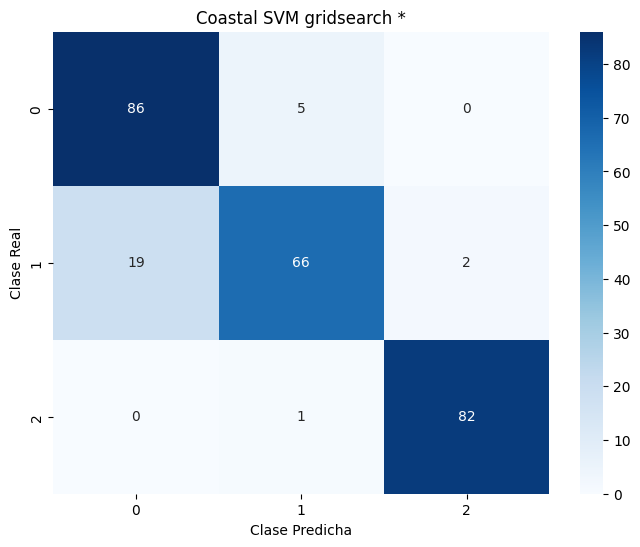

In [167]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal SVM gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [168]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


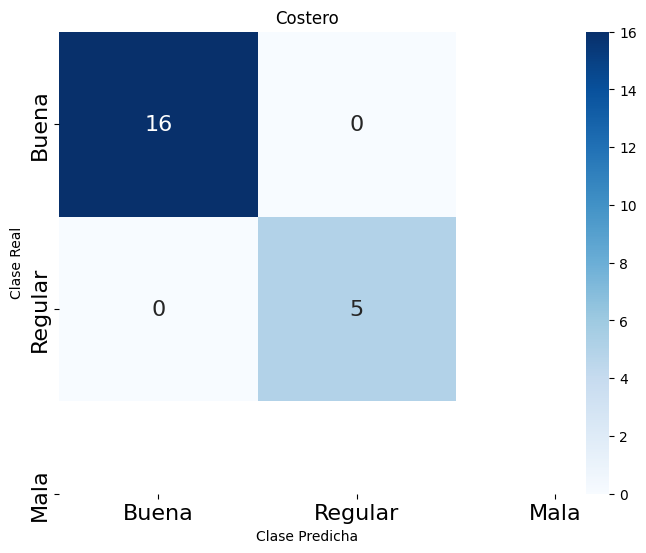

In [169]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Costero')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####KNN

In [170]:
# Define a dictionary of hyperparameters for tuning a KNN model
parameters = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de ponderación
    'p': [1, 2]  # Parámetro para la distancia (1 para la distancia de Manhattan, 2 para la Euclidiana)
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_knn = KNeighborsClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_knn, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_knn.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, Accuracy: 0.8199233716475096, Best score (cv): 0.7646577107103423
Best model: KNeighborsClassifier(n_neighbors=3, weights='distance')
Best params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best score: 0.7646577107103423


######Metrics

 Evaluate the model on the training set

In [171]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[343   0   0]
 [  0 347   0]
 [  0   0 351]]


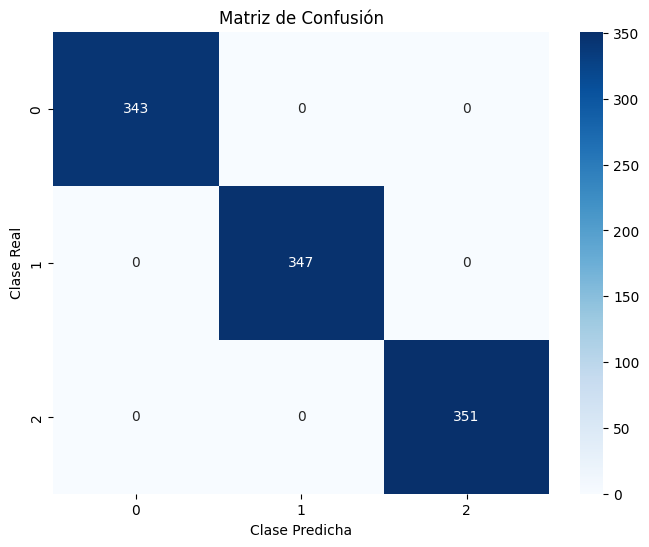

In [172]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [173]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8199233716475096
Precision:  0.8212492987727188
Precision per class: [0.81372549 0.81521739 0.8358209 ]
Recall:  0.8199233716475096
Recall per class: [0.91208791 0.86206897 0.6746988 ]
F1 Score:  0.8166582042839375
F1-score for the class 0: 0.8601036269430051
F1-score for the class 1: 0.8379888268156425
F1-score for the class 2: 0.7466666666666667
jaccard: 1.0
Confusion Matrix: 
[[83  2  6]
 [ 7 75  5]
 [12 15 56]]


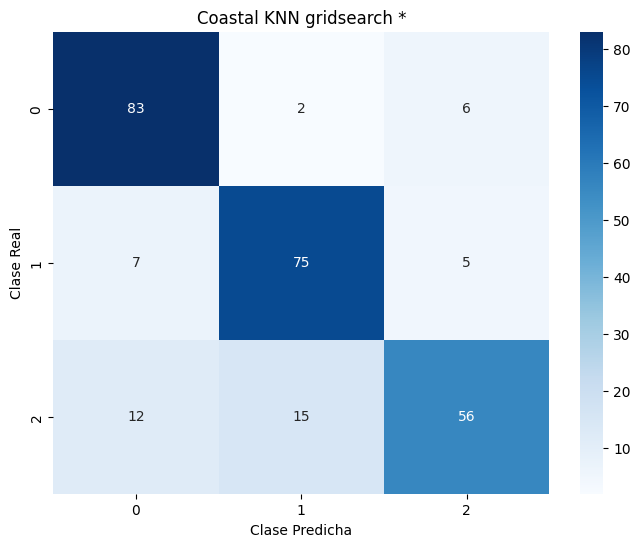

In [174]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal KNN gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [175]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9523809523809523
Precision:  1.0
Precision per class: [1. 1. 0.]
Recall:  0.9523809523809523
Recall per class: [0.9375 1.     0.    ]
F1 Score:  0.9754224270353303
F1-score for the class 0: 0.967741935483871
F1-score for the class 1: 1.0
F1-score for the class 2: 0.0
jaccard: 0.9523809523809523
Confusion Matrix: 
[[15  0  1]
 [ 0  5  0]
 [ 0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


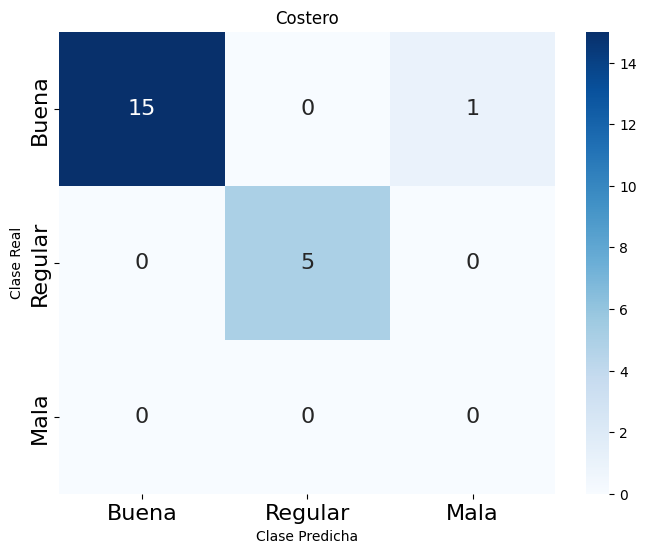

In [176]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Costero')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####DT

In [177]:
# Define a dictionary of hyperparameters for tuning a DT model
parameters = {
    'criterion': ['gini', 'entropy'],  # Criterio para la división de nodos
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en una hoja
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_dt = DecisionTreeClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_dt, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_dt.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}, Accuracy: 1.0, Best score (cv): 0.9903892160471109
Best model: DecisionTreeClassifier(criterion='entropy', max_depth=30)
Best params: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.9903892160471109


######Metrics

 Evaluate the model on the training set

In [178]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[343   0   0]
 [  0 347   0]
 [  0   0 351]]


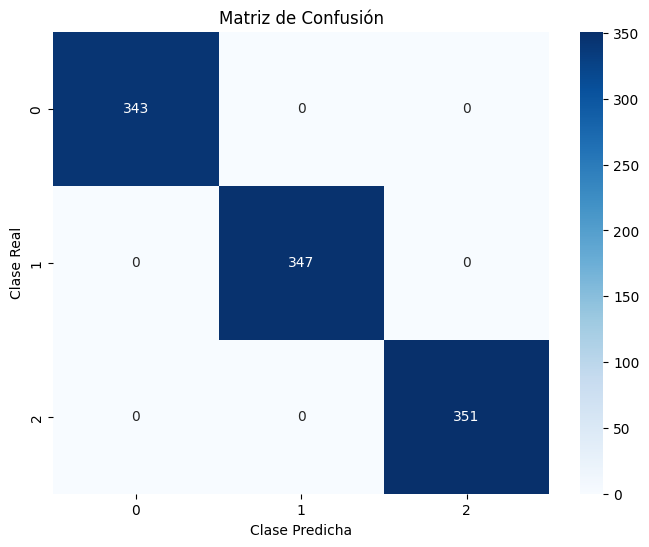

In [179]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [180]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[91  0  0]
 [ 0 87  0]
 [ 0  0 83]]


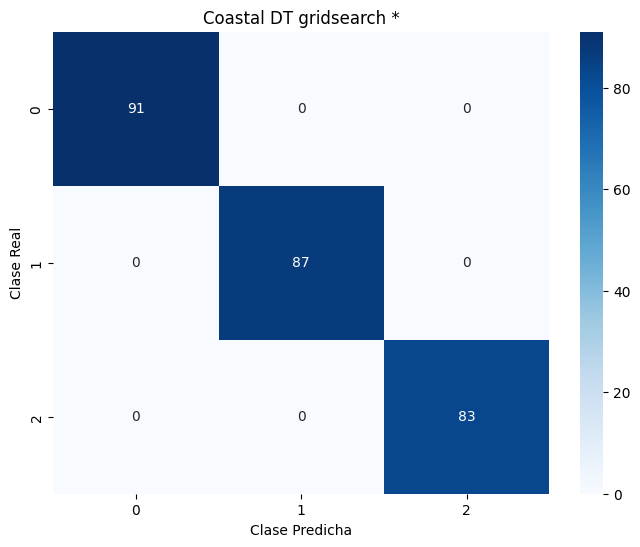

In [181]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal DT gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [182]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


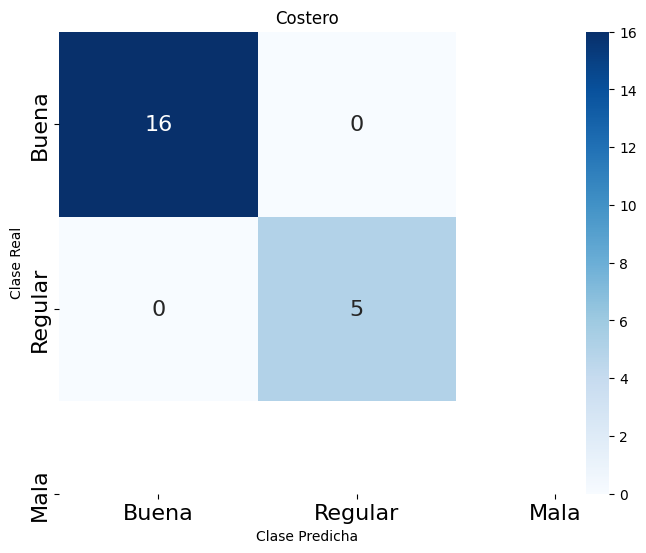

In [183]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Costero')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####MLR

In [184]:
# Define a dictionary of hyperparameters for tuning a MLR model
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Método de optimización
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_coastal_mlr = LogisticRegression(max_iter=1000)  # Usamos max_iter para evitar advertencias

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_coastal_mlr, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_coastal_mlr.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best params: {'C': 100, 'solver': 'newton-cg'}, Accuracy: 0.8850574712643678, Best score (cv): 0.9212504600662494
Best model: LogisticRegression(C=100, max_iter=1000, solver='newton-cg')
Best params: {'C': 100, 'solver': 'newton-cg'}
Best score: 0.9212504600662494


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


######Metrics

 Evaluate the model on the training set

In [185]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9289145052833814
Precision:  0.9316629910673443
Precision per class: [0.86243386 0.94533762 0.98579545]
Recall:  0.9289145052833814
Recall per class: [0.95043732 0.84726225 0.98860399]
F1 Score:  0.9286899757949204
F1-score for the class 0: 0.9042995839112344
F1-score for the class 1: 0.8936170212765957
F1-score for the class 2: 0.9871977240398293
jaccard: 0.8698166950695584
Confusion Matrix: 
[[326  16   1]
 [ 49 294   4]
 [  3   1 347]]


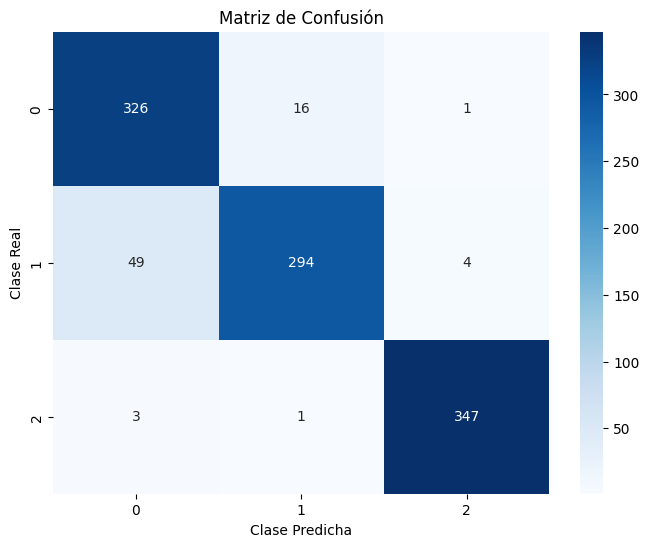

In [186]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [187]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8850574712643678
Precision:  0.8871512060496808
Precision per class: [0.82352941 0.89041096 0.95348837]
Recall:  0.8850574712643678
Recall per class: [0.92307692 0.74712644 0.98795181]
F1 Score:  0.8829284058673773
F1-score for the class 0: 0.8704663212435233
F1-score for the class 1: 0.8125
F1-score for the class 2: 0.9704142011834319
jaccard: 0.8698166950695584
Confusion Matrix: 
[[84  7  0]
 [18 65  4]
 [ 0  1 82]]


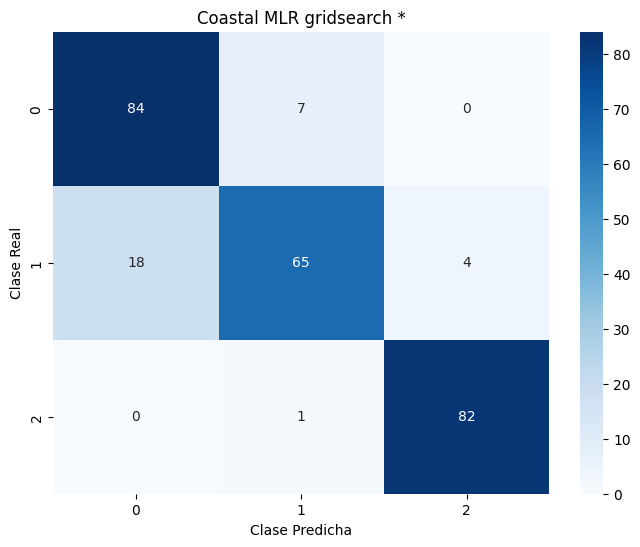

In [188]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Coastal MLR gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [189]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_coastal_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_coastal_num, y_pred)
precision = precision_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_coastal_num, y_pred, average=None)
recall = recall_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_coastal_num, y_pred, average=None)
f1 = f1_score(y_val_coastal_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_coastal_num, y_pred, average=None)
jaccard = jaccard_score(y_val_coastal_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_coastal_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9523809523809523
Precision:  0.9603174603174603
Precision per class: [1.         0.83333333]
Recall:  0.9523809523809523
Recall per class: [0.9375 1.    ]
F1 Score:  0.9537774053903088
F1-score for the class 0: 0.967741935483871
F1-score for the class 1: 0.9090909090909091
jaccard: 0.9126984126984128
Confusion Matrix: 
[[15  1]
 [ 0  5]]


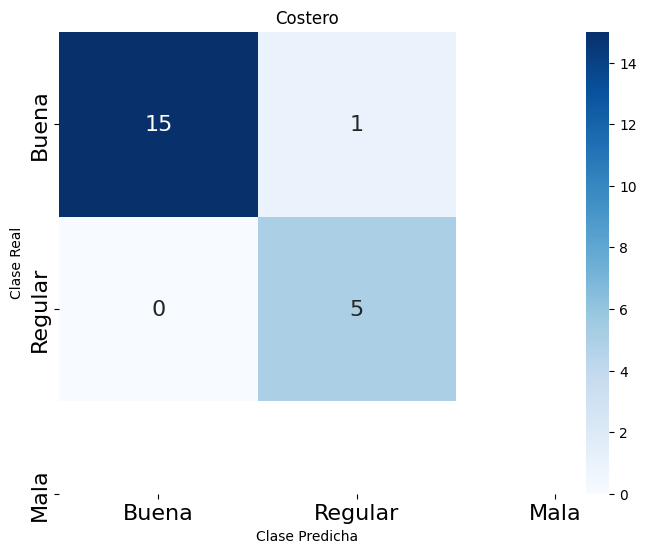

In [190]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_coastal_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Costero')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####Empaquetado del escalador

In [191]:
# Save the scaler used for preprocessing to a file
#with open('scaler_coa.pkl', 'wb') as scaler_file:
#    pickle.dump(scaler_coa, scaler_file)